Three machines make metal parts for industries like aerospace and automotive. To avoid delays, it’s important to reduce machine downtime.

The company is using past data on machine breakdowns to predict future downtime and plan maintenance early.

This analysis is the first step toward making machines more reliable.


## Objectives:

EDA: Find patterns and key reasons behind machine failures to take action before problems happen.

Machine Learning: Use predictive models to plan maintenance in advance, rather than waiting for machines to break down.

Monitoring: Set up strategies for ongoing monitoring and continuous improvement.



In [ ]:

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import missingno as msno
from scipy.stats import kurtosis
from scipy.stats import skew
import math
from sklearn.metrics import precision_recall_curve, average_precision_score
import shap
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
df  = pd.read_excel("/content/machinedowntimedatasql.xlsx")

In [ ]:
df.head()

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,71.04,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
1,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,125.33,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2,31-12-2021,Makino-L3-Unit1-2015,Shopfloor-L3,71.12,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
3,31-05-2022,Makino-L2-Unit1-2015,Shopfloor-L2,139.34,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
4,31-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,60.51,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure


| **Feature**                       | **Description**                  | **Unit**             | **Purpose**                                                    |
| --------------------------------- | -------------------------------- | -------------------- | -------------------------------------------------------------- |
| **Date**                          | Date of machine reading          | Date                 | Tracks changes over time and helps analyze maintenance trends  |
| **Machine\_ID**                   | Unique ID for each machine       | Categorical          | Allows comparison between different machines                   |
| **Assembly\_Line\_No**            | ID for the assembly line         | Categorical          | Enables comparison across different assembly lines             |
| **Hydraulic\_Pressure**           | Pressure in the hydraulic system | Bar                  | Indicates the health of the hydraulic system                   |
| **Coolant\_Pressure**             | Pressure in the coolant system   | Bar                  | Reflects how well the cooling system is working                |
| **Air\_System\_Pressure**         | Pressure in the air system       | Bar                  | Assesses air compression system status                         |
| **Coolant\_Temperature**          | Temperature of the coolant       | °C                   | Helps monitor the coolant system's efficiency                  |
| **Hydraulic\_Oil\_Temperature**   | Temperature of hydraulic oil     | °C                   | Assesses hydraulic system performance                          |
| **Spindle\_Bearing\_Temperature** | Temperature of spindle bearings  | °C                   | Indicates potential issues in the spindle system               |
| **Spindle\_Vibration**            | Vibration level of the spindle   | Micrometers          | Measures spindle condition and wear                            |
| **Tool\_Vibration**               | Vibration level of the tool      | Micrometers          | Monitors tool condition and performance                        |
| **Spindle\_Speed**                | Rotation speed of the spindle    | RPM                  | Evaluates how the spindle is performing                        |
| **Voltage**                       | System voltage                   | Volts                | Tracks the health of electrical components                     |
| **Torque**                        | Rotational force                 | Newton-meters (Nm)   | Reflects mechanical load on the system                         |
| **Cutting**                       | Cutting force applied            | Kilonewtons (kN)     | Evaluates the strength and stability during cutting operations |
| **Downtime**                      | Whether the machine was down     | Boolean (True/False) | Indicates if a machine experienced a failure or not            |


The data contains continuous readings from machines on the shop floor, tracking key factors like pressure, temperature, torque, and speed to monitor machine health and performance.

All the machine data is stored in one table, where each row represents one machine’s reading for a specific day. However, there’s no information about how the data was collected, which makes it hard to judge its quality.


In [ ]:
df.columns

Index(['Date', 'Machine_ID', 'Assembly_Line_No', 'Hydraulic_Pressure(bar)',
       'Coolant_Pressure(bar)', 'Air_System_Pressure(bar)',
       'Coolant_Temperature', 'Hydraulic_Oil_Temperature(?C)',
       'Spindle_Bearing_Temperature(?C)', 'Spindle_Vibration(?m)',
       'Tool_Vibration(?m)', 'Spindle_Speed(RPM)', 'Voltage(volts)',
       'Torque(Nm)', 'Cutting(kN)', 'Downtime'],
      dtype='object')

In [ ]:
columns_names_dict = {
    "Hydraulic_Pressure(bar)" : "Hydraulic_Pressure",
    "Coolant_Pressure(bar)" : "Coolant_Pressure",
    "Air_System_Pressure(bar)" : "Air_System_Pressure",
    "Hydraulic_Oil_Temperature(?C)": "Hydraulic_Oil_Temperature",
    "Spindle_Bearing_Temperature(?C)": "Spindle_Bearing_Temperature",
    "Spindle_Vibration(?m)": "Spindle_Vibration",
    "Tool_Vibration(?m)": "Tool_Vibration",
    "Spindle_Speed(RPM)" : "Spindle_Speed",
    "Voltage(volts)" : "Voltage",
    "Torque(Nm)" : "Torque",
    "Cutting(kN)" : "Cutting"
}

In [ ]:
columns_print_names={
    "Date": "Date of the reading",
    "Machine_ID": "Machine",
    "Assembly_Line_No": "Assembly Line",
    "Hydraulic_Pressure": "Hydraulic Pressure",
    "Coolant_Pressure": "Coolant Pressure",
    "Air_System_Pressure": "Air System Pressure",
    "Coolant_Temperature": "Coolant Temperature",
    "Hydraulic_Oil_Temperature": "Hydraulic Oil Temperature",
    "Spindle_Bearing_Temperature": "Spindle Bearing Temperature",
    "Spindle_Vibration": "Spindle Vibration",
    "Tool_Vibration": "Tool Vibration",
    "Spindle_Speed": "Spindle Speed",
    "Voltage": "Voltage",
    "Torque": "Torque",
    "Cutting": "Cutting",
    "Downtime": "Downtime"
}

In [ ]:
units_dict = {
    "Date": "",
    "Machine_ID": "",
    "Assembly_Line_No": "",
    "Hydraulic_Pressure" : "bar",
    "Coolant_Pressure" : "bar",
    "Air_System_Pressure" : "bar",
    "Coolant_Temperature": " Celsius",
    "Hydraulic_Oil_Temperature": " Celsius",
    "Spindle_Bearing_Temperature": " Celsius",
    "Spindle_Vibration": "micrometer",
    "Tool_Vibration": "micrometer",
    "Spindle_Speed" : "RPM",
    "Voltage" : "volts",
    "Torque" : "Nm",
    "Cutting" : "kN",
    "Downtime": ""
}

In [ ]:
# Generate a colorblind-friendly palette with 20 colors
tol_palette = [
    "#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77",
    "#CC6677", "#882255", "#AA4499", "#661100", "#6699CC", "#AA4466",
    "#4477AA", "#DDDDDD", "#000000", "#F0E442", "#D55E00", "#009E73",
    "#E69F00", "#56B4E9", "#0072B2"
]
palette = tol_palette
custom_palette = {0: palette[6], 1: palette[2]}
sns.set_palette(palette)
sns.set_style("darkgrid")

In [ ]:
#color mappings are used to visually distinguish different assembly lines and machines in plots

assembly_line_color_map = {"Shopfloor-L1": palette[0], "Shopfloor-L2": palette[1], "Shopfloor-L3": palette[2]}

machine_color_map = {"Makino-L1-Unit1-2013": palette[0], "Makino-L2-Unit1-2015": palette[1], "Makino-L3-Unit1-2015": palette[2]}

assembly_line_downtime_color_map = {"Shopfloor-L1": palette[7], "Shopfloor-L2": palette[8], "Shopfloor-L3": palette[9]}

machine_downtime_color_map = {"Makino-L1-Unit1-2013": palette[7], "Makino-L2-Unit1-2015": palette[8], "Makino-L3-Unit1-2015": palette[9]}

In [ ]:
#renaming

df.rename(columns=columns_names_dict, inplace=True)

In [ ]:
# Re-writing values
downtime_map = {1: 'Machine Failure', 0: 'No Machine Failure'}
df['Downtime'] = df['Downtime'].replace({'Machine_Failure': 1, 'No_Machine_Failure': 0})


/tmp/ipykernel_31/669909777.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Downtime'] = df['Downtime'].replace({'Machine_Failure': 1, 'No_Machine_Failure': 0})


In [ ]:
# Casting
df['Machine_ID'] = df['Machine_ID'].astype('category')
df['Assembly_Line_No'] = df['Assembly_Line_No'].astype('category')
df['Downtime'] = df['Downtime'].astype('int')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.sort_values(by="Date", ascending=True, inplace=True)



In [ ]:
# Unique values
target_col = 'Downtime'
index_col = 'Date'
categorical_col = ['Machine_ID', 'Assembly_Line_No']
numerical_col = []

for column in df.columns:
    if (df[column].dtype == 'float64'):
        numerical_col.append(column)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2500 entries, 466 to 2253
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         2500 non-null   datetime64[ns]
 1   Machine_ID                   2500 non-null   category      
 2   Assembly_Line_No             2500 non-null   category      
 3   Hydraulic_Pressure           2490 non-null   float64       
 4   Coolant_Pressure             2481 non-null   float64       
 5   Air_System_Pressure          2483 non-null   float64       
 6   Coolant_Temperature          2488 non-null   float64       
 7   Hydraulic_Oil_Temperature    2484 non-null   float64       
 8   Spindle_Bearing_Temperature  2493 non-null   float64       
 9   Spindle_Vibration            2489 non-null   float64       
 10  Tool_Vibration               2489 non-null   float64       
 11  Spindle_Speed                2494 non-null   f

The data has undergone transformations to enhance analysis, including renaming columns, casting data types, and mapping target class values.

In [ ]:


# Basic dataset summary
start_date = df['Date'].min()
end_date = df['Date'].max()
total_days = (end_date - start_date).days
total_months = total_days // 30
total_weeks = total_days // 7

print(f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"Date range: {start_date.strftime('%d-%m-%Y')} to {end_date.strftime('%d-%m-%Y')} (~{total_months} months or {total_days} days).")
print(f"{df['Machine_ID'].nunique()} unique machines from {df['Assembly_Line_No'].nunique()} assembly lines.")
print(f"{df['Downtime'].nunique()} operational statuses (Normal or Downtime).")


Dataset has 2500 rows and 16 columns.
Date range: 24-11-2021 to 03-07-2022 (~7 months or 221 days).
3 unique machines from 3 assembly lines.
2 operational statuses (Normal or Downtime).


In [ ]:
# Count missing values
missing_summary = df.isna().sum().reset_index(name='Missing Count')
missing_summary['Normalized (%)'] = (missing_summary['Missing Count'] / len(df)) * 100
missing_summary = missing_summary.rename(columns={'index': 'Feature'}).sort_values('Missing Count', ascending=False)

# Get the feature with the most missing values
top_missing_feature = missing_summary.iloc[0]['Feature']


print(f"There are {df.duplicated().sum()} duplicates in the dataset.")
print(f"Top feature with missing values: {top_missing_feature}")


There are 0 duplicates in the dataset.
Top feature with missing values: Torque


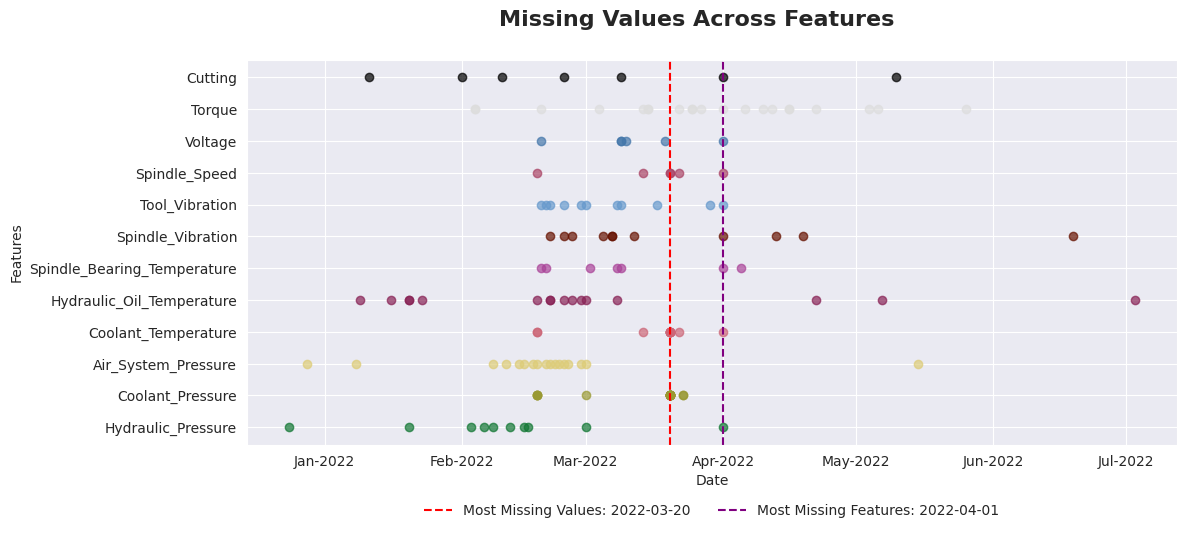

In [ ]:


# Calculate missing values by date
missing_by_date = df.isna().sum(axis=1).groupby(df['Date']).sum()
most_missing_date = missing_by_date.idxmax()
most_missing_features_by_date = df.isna().groupby(df['Date']).apply(lambda x: x.any().sum()).idxmax()

# Plot missing data timeline
fig, ax = plt.subplots(figsize=(12, 5))

for feature in df.columns:
    missing_data = df[df[feature].isna()]
    ax.scatter(missing_data['Date'], [feature] * len(missing_data), alpha=0.7)

# Add vertical lines for the dates with the most missing values and features
ax.axvline(most_missing_date, color='red', linestyle='--', label=f'Most Missing Values: {most_missing_date.date()}')
ax.axvline(most_missing_features_by_date, color='purple', linestyle='--', label=f'Most Missing Features: {most_missing_features_by_date.date()}')

# Set labels, title, and date formatting
ax.set_xlabel('Date')
ax.set_ylabel('Features')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Add legend and title
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
fig.suptitle("Missing Values Across Features", weight='bold', fontsize=16)

plt.show()


The day with the most missing values was March 20, 2022, with a total of 21 missing values.

The day with the most missing features was April 1, 2022, when 9 features had missing values.

In [ ]:
# Missing values by machine
for machine_id in sorted(df['Machine_ID'].unique()):
    assembly_line = df[df['Machine_ID'] == machine_id]['Assembly_Line_No'].head(1).values[0]
    print(f"Machine_ID '{machine_id}' (Assembly Line '{assembly_line}') has {df[df['Machine_ID'] ==machine_id].isna().sum().sum()} missing values.")

Machine_ID 'Makino-L1-Unit1-2013' (Assembly Line 'Shopfloor-L1') has 49 missing values.
Machine_ID 'Makino-L2-Unit1-2015' (Assembly Line 'Shopfloor-L2') has 57 missing values.
Machine_ID 'Makino-L3-Unit1-2015' (Assembly Line 'Shopfloor-L3') has 37 missing values.


There are three machines, one for each assembly line.

The machine ID Makino-L2-Unit1-2015 (from the assembly line Shopfloor-L2) has the most missing values.

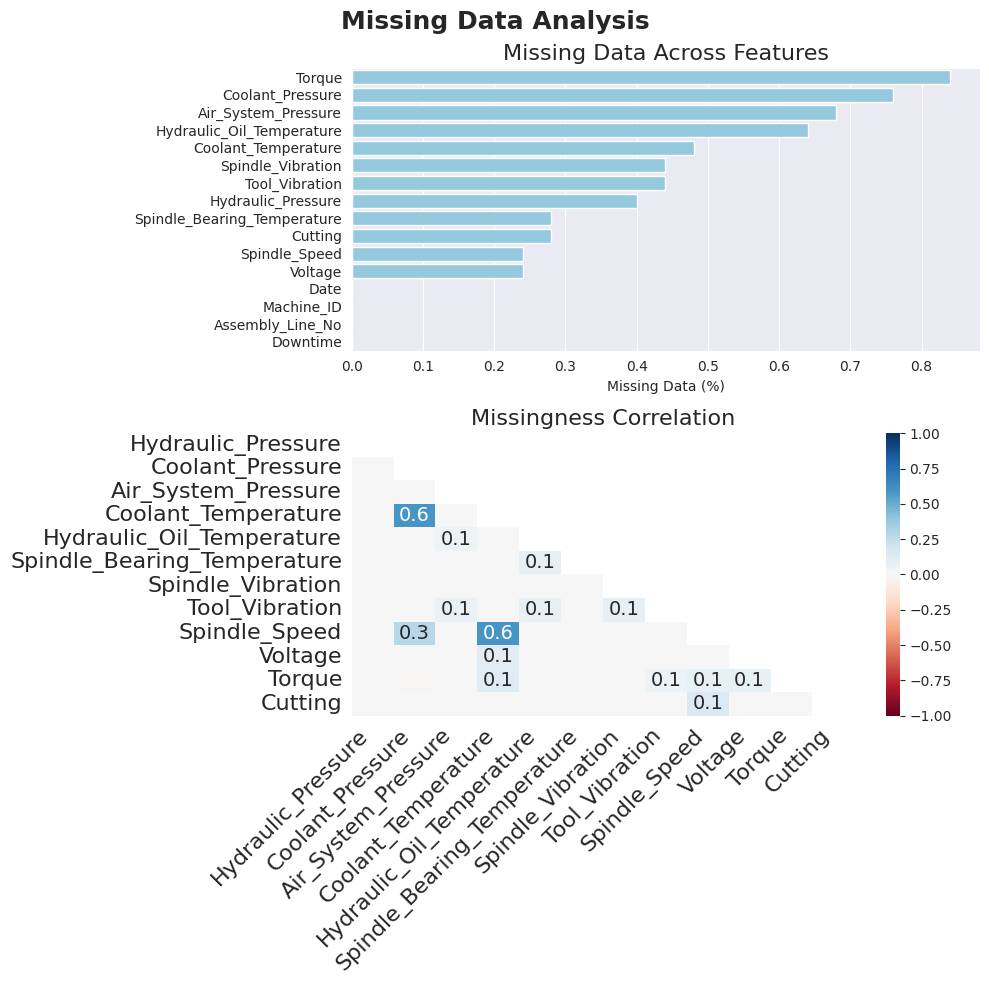

In [ ]:


# Step 1: Count missing values
missing_df = df.isna().sum()
normalized_missing = (missing_df / len(df)) * 100

# Step 2: Create a summary DataFrame
missing_summary = pd.DataFrame({
    'feature': missing_df.index,
    'Missing Count': missing_df.values,
    'Normalized (%)': normalized_missing.round(2).values
}).sort_values('Missing Count', ascending=False)

# Step 3: Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Subplot 1: Bar plot of missing % per feature
sns.barplot(data=missing_summary, y='feature', x='Normalized (%)', color='skyblue', ax=axes[0])
axes[0].set_title('Missing Data Across Features', fontsize=16)
axes[0].set_xlabel('Missing Data (%)')
axes[0].set_ylabel('')

# Subplot 2: Missing data correlation heatmap
msno.heatmap(df, ax=axes[1])
axes[1].set_title('Missingness Correlation', fontsize=16)

# Add overall title
fig.suptitle('Missing Data Analysis', fontsize=18, weight='bold')
plt.tight_layout()
plt.show()


Some sensors like Torque, Coolant Pressure, Air System Pressure, and Hydraulic Oil Temperature have slightly higher missing values (around 0.5%). Missing data is likely due to harsh conditions or sensor issues. Also, features like Coolant Temperature, Spindle Speed, and Coolant Pressure often go missing together, suggesting shared sensors or related processes

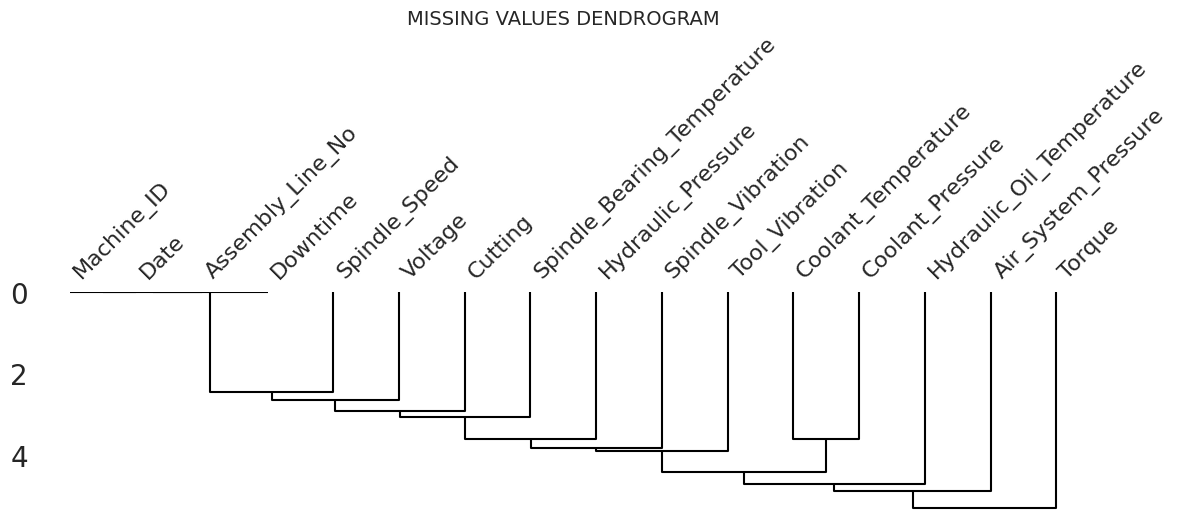

In [ ]:
# Dendrogram of missigness
fig, axes = plt.subplots(1, 1, sharey=False, figsize=(12, 6))
ax = axes
msno.dendrogram(df, ax=ax)
ax.set_title('Missing Values Dendrogram'.upper(), fontsize=14)
#fig.suptitle('Missing Values on Dataset Features'.upper(), weight='bold', fontsize=16)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust rect to fit the title
plt.show()

Spindle_Speed shows some connection to operational features like Date, Machine_ID, and Downtime, suggesting its missing values may depend on machine operations. Other features show independent missing patterns, meaning their missing data likely comes from separate causes, not shared issues.

The dataset is clean with minimal missing data (<1%), no duplicates, and suitable for median imputation. Some missing values are likely linked to sensor issues or operations. Further analysis is needed to confirm causes and explore machine failure patterns

The dataset spans 7 months with near-daily readings. Data collection started in Nov 2021 and ended by July 2022. Machines began logging at different times, with readings unevenly distributed and notable gaps, especially at the start and end.

In [ ]:
# Distribution of readings across machines
df.groupby(['Machine_ID'])['Assembly_Line_No'].count().to_frame().rename(columns={'Assembly_Line_No': 'Total_readings'}).transpose()

/tmp/ipykernel_31/2229217664.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Machine_ID'])['Assembly_Line_No'].count().to_frame().rename(columns={'Assembly_Line_No': 'Total_readings'}).transpose()


Machine_ID,Makino-L1-Unit1-2013,Makino-L2-Unit1-2015,Makino-L3-Unit1-2015
Total_readings,874,808,818


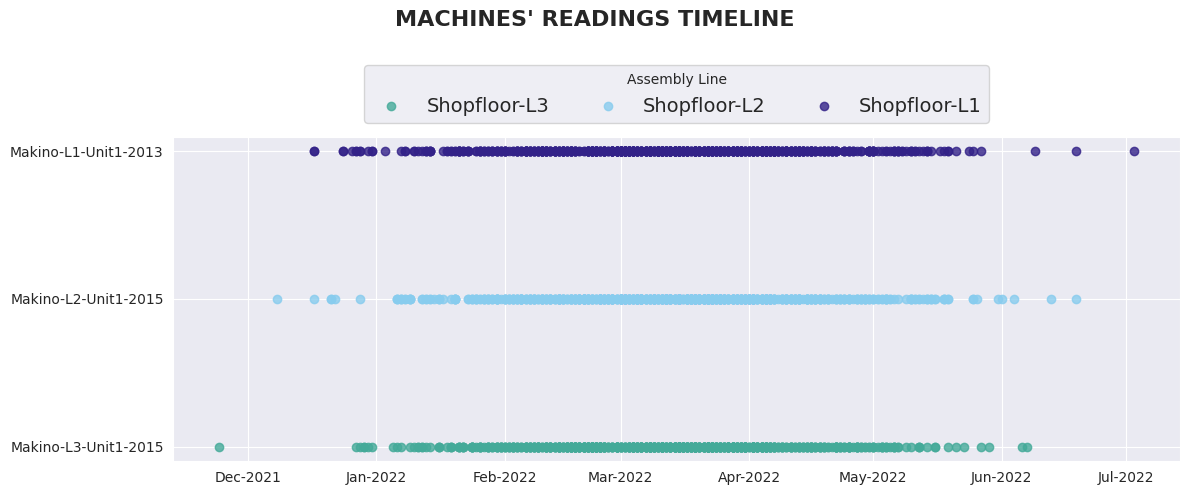

In [ ]:
# Timeline of machine readings
fig, ax = plt.subplots(figsize=(12, 5))

# Get unique combinations of Machine_ID and Assembly_Line_No
combinations = df[['Machine_ID', 'Assembly_Line_No']].drop_duplicates()

# Plot each machine's readings over time
plotted_labels = set()
for _, row in combinations.iterrows():
    machine_id, line_no = row['Machine_ID'], row['Assembly_Line_No']
    data = df[(df['Machine_ID'] == machine_id) & (df['Assembly_Line_No'] == line_no)].sort_values('Date')
    color = assembly_line_color_map[line_no]

    # Plot points with label shown only once per assembly line
    ax.scatter(data['Date'], [machine_id]*len(data), color=color, alpha=0.8,
               label=line_no if line_no not in plotted_labels else None, zorder=3)
    plotted_labels.add(line_no)

# Customize plot
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(title=columns_print_names['Assembly_Line_No'], bbox_to_anchor=(0.5, 1.25),
          loc='upper center', ncol=3, frameon=True, fontsize=14)
fig.suptitle("Machines' Readings Timeline".upper(), weight='bold', fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the difference between readings dates by Machine_ID
print("GAPS BETWEEN READINGS (IN DAYS) BY MACHINE:".upper())

date_diffs_by_machine = (
    df.groupby('Machine_ID')['Date']
    .apply(lambda x: x.sort_values().diff().dt.days)
)
date_diffs_by_machine.groupby('Machine_ID').describe()

GAPS BETWEEN READINGS (IN DAYS) BY MACHINE:


/tmp/ipykernel_31/1844868584.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('Machine_ID')['Date']
/tmp/ipykernel_31/1844868584.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  date_diffs_by_machine.groupby('Machine_ID').describe()


,count,mean,std,min,25%,50%,75%,max
Machine_ID,,,,,,,,
Makino-L1-Unit1-2013,873.0,0.226804,0.877270,0.0,0.0,0.0,0.0,14.0
Makino-L2-Unit1-2015,807.0,0.239157,0.794555,0.0,0.0,0.0,0.0,9.0
Makino-L3-Unit1-2015,817.0,0.238678,1.273051,0.0,0.0,0.0,0.0,33.0


In [ ]:
# Longest consecutive reading period per machine
print("Longest consecutive reading period per machine:\n".upper())

longest_periods = []

for machine, machine_dates in df.groupby('Machine_ID')['Date']:
    sorted_dates = machine_dates.drop_duplicates().sort_values()
    date_gaps = sorted_dates.diff().dt.days > 1  # True where gap > 1 day
    group_labels = date_gaps.cumsum()  # Label each consecutive block

    # Group dates by each consecutive period
    grouped_periods = sorted_dates.groupby(group_labels)

    # Find the longest block
    longest = max(grouped_periods, key=lambda g: (g[1].max() - g[1].min()).days, default=None)

    if longest:
        start, end = longest[1].min(), longest[1].max()
        duration = (end - start).days + 1
        longest_periods.append((machine, start, end, duration))

        print(f"{machine}")
        print(f"  Period: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} ({duration} days)\n")


LONGEST CONSECUTIVE READING PERIOD PER MACHINE:

Makino-L1-Unit1-2013
  Period: 2022-01-25 to 2022-04-22 (88 days)

Makino-L2-Unit1-2015
  Period: 2022-01-23 to 2022-05-07 (105 days)

Makino-L3-Unit1-2015
  Period: 2022-01-24 to 2022-05-07 (104 days)



/tmp/ipykernel_31/2607296964.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for machine, machine_dates in df.groupby('Machine_ID')['Date']:
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


📈 January to mid-March: Daily readings increased, peaking at a 7-day rolling average of 12+ readings/day.

📉 After mid-March: Readings declined, stabilizing at ~3 per day from May onward.

📊 Overall average: About 5 daily readings.

⚠️ Notable outlier: Shopfloor-L2 had spikes, with up to 27 readings in one day.

In [ ]:
# Daily Readings distribution by Assembly_Line_No
readings_count = df.groupby(['Date', 'Assembly_Line_No'])['Machine_ID'].count().reset_index(name='readings_per_day')

print("Daily Readings by Assembly Line:".upper())
readings_count.groupby('Assembly_Line_No')['readings_per_day'].describe()

DAILY READINGS BY ASSEMBLY LINE:


/tmp/ipykernel_31/168965470.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readings_count = df.groupby(['Date', 'Assembly_Line_No'])['Machine_ID'].count().reset_index(name='readings_per_day')
/tmp/ipykernel_31/168965470.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readings_count.groupby('Assembly_Line_No')['readings_per_day'].describe()


,count,mean,std,min,25%,50%,75%,max
Assembly_Line_No,,,,,,,,
Shopfloor-L1,164.0,5.329268,4.872749,0.0,1.0,4.0,9.0,22.0
Shopfloor-L2,164.0,4.926829,4.468789,0.0,1.0,4.0,7.0,27.0
Shopfloor-L3,164.0,4.987805,4.721687,0.0,1.0,4.0,8.0,20.0


/tmp/ipykernel_31/3034520379.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readings_count['rolling_avg'] = readings_count.groupby('Assembly_Line_No')['readings_per_day'].transform(lambda x: x.rolling(7, min_periods=1).mean())
/tmp/ipykernel_31/3034520379.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readings_count['rolling_std'] = readings_count.groupby('Assembly_Line_No')['readings_per_day'].transform(lambda x: x.rolling(7, min_periods=1).std())
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future versi

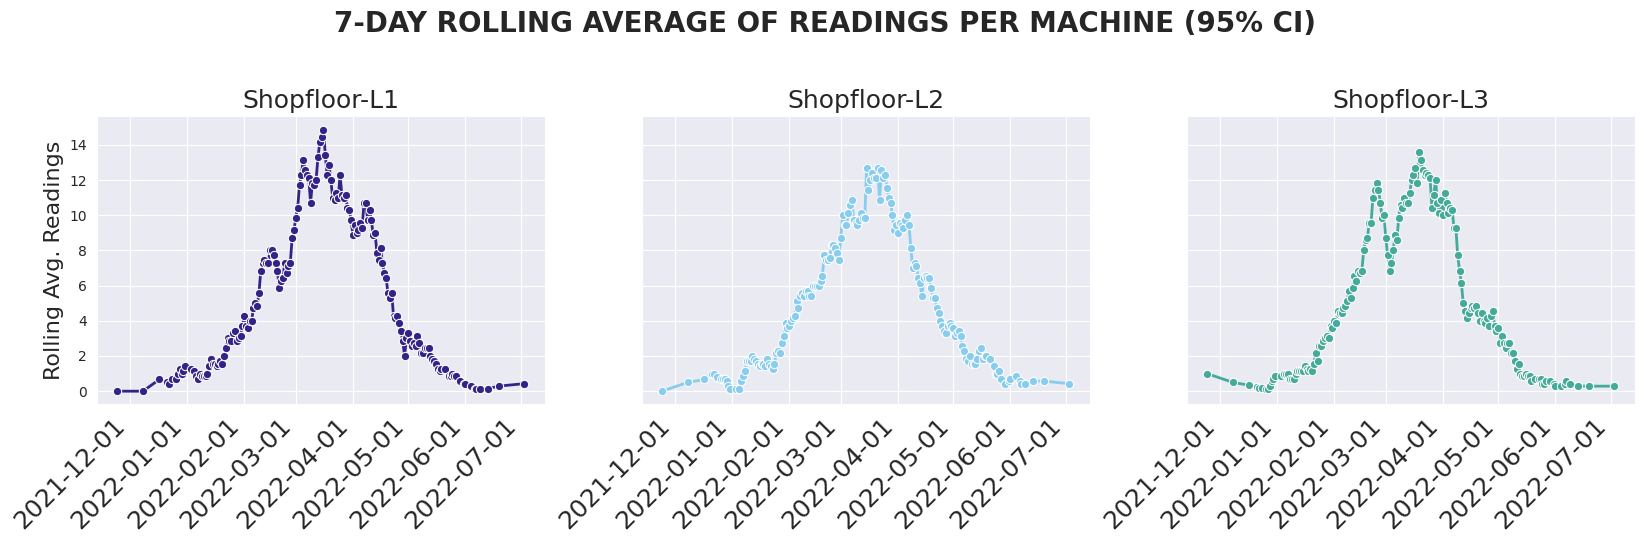

In [ ]:
# 7-Day Rolling Average with 95% CI
readings_count['rolling_avg'] = readings_count.groupby('Assembly_Line_No')['readings_per_day'].transform(lambda x: x.rolling(7, min_periods=1).mean())
readings_count['rolling_std'] = readings_count.groupby('Assembly_Line_No')['readings_per_day'].transform(lambda x: x.rolling(7, min_periods=1).std())

# Calculate 95% CI
readings_count['ci_lower'] = readings_count['rolling_avg'] - 1.96 * readings_count['rolling_std'] / np.sqrt(7)
readings_count['ci_upper'] = readings_count['rolling_avg'] + 1.96 * readings_count['rolling_std'] / np.sqrt(7)

# FacetGrid Plot
g = sns.FacetGrid(data=readings_count, col='Assembly_Line_No', col_wrap=3, height=5.5, sharey=True)
g.map_dataframe(lambda data, **kwargs: sns.lineplot(data=data, x='Date', y='rolling_avg',
                                                    color=assembly_line_color_map[data['Assembly_Line_No'].iloc[0]],
                                                    lw=2, marker='o') or plt.fill_between(data['Date'], data['ci_lower'], data['ci_upper'], alpha=0.2, color='gray'))

# Adjust Plot Aesthetics
g.set_axis_labels('', 'Rolling Avg. Readings', fontsize=16)
g.set_titles(col_template="{col_name}", size=18)
g.set_xticklabels(rotation=45, horizontalalignment='right', fontsize=18)
g.fig.suptitle("7-Day Rolling Average of Readings Per Machine (95% CI)\n".upper(), weight='bold', fontsize=20)

plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()


In [ ]:


column_name = 'readings_per_day'#'rolling_avg'
print("Skewness of daily readings across machines: ".upper())
print(readings_count.groupby('Assembly_Line_No')[column_name].apply(skew))

print("\nKurtosis of the daily readings across machines: ".upper())
print(readings_count.groupby('Assembly_Line_No')[column_name].apply(kurtosis))

print("\nOverall stats of the daily readings across machines: ".upper())
print(readings_count.groupby('Assembly_Line_No')[column_name].describe().round(2))

SKEWNESS OF DAILY READINGS ACROSS MACHINES: 
Assembly_Line_No
Shopfloor-L1    0.865438
Shopfloor-L2    1.225938
Shopfloor-L3    0.928379
Name: readings_per_day, dtype: float64

KURTOSIS OF THE DAILY READINGS ACROSS MACHINES: 
Assembly_Line_No
Shopfloor-L1   -0.028386
Shopfloor-L2    2.481788
Shopfloor-L3    0.156382
Name: readings_per_day, dtype: float64

OVERALL STATS OF THE DAILY READINGS ACROSS MACHINES: 
                  count  mean   std  min  25%  50%  75%   max
Assembly_Line_No                                             
Shopfloor-L1      164.0  5.33  4.87  0.0  1.0  4.0  9.0  22.0
Shopfloor-L2      164.0  4.93  4.47  0.0  1.0  4.0  7.0  27.0
Shopfloor-L3      164.0  4.99  4.72  0.0  1.0  4.0  8.0  20.0


/tmp/ipykernel_31/4139900340.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(readings_count.groupby('Assembly_Line_No')[column_name].apply(skew))
/tmp/ipykernel_31/4139900340.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(readings_count.groupby('Assembly_Line_No')[column_name].apply(kurtosis))
/tmp/ipykernel_31/4139900340.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(readings_count.group

Dataset Duration: The data covers 7 months with mostly daily readings, but there are some gaps, especially at the start and end. This could be due to issues with data collection, sensors, or reporting.

Readings Fluctuations: The number of readings per day varied a lot, peaking above 12 per day and then dropping to around 3. This might be caused by irregular data logging or differences between machines.

## Next Steps:

Look into the gaps, especially at the beginning and end, and see if they relate to maintenance or operational changes.

Investigate why the data collection frequency changed and try to make the monitoring more consistent.










## Data Gaps and Frequency:

Sometimes, the data is missing or not recorded regularly. This can make downtime look smaller than it actually is.

More frequent readings give a better picture of downtime, but big gaps can distort the results.

## Improvement Needed:

We need to investigate why there are gaps in the data and fix how and when it’s collected.

By improving data collection, the downtime insights will be more accurate.

## Key Observation:

When more readings were taken (from January to May 2022), downtime also increased. This suggests the system was preparing for downtime by recording more data during that time.

/tmp/ipykernel_31/1244761216.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_assembly_line_count = df.groupby(['Week', 'Assembly_Line_No']).size().reset_index(name='entry_count')
/tmp/ipykernel_31/1244761216.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  downtime_by_assembly_line_weekly = df.groupby(['Week', 'Assembly_Line_No'])['Downtime'].sum().reset_index(name='Downtime_occurrences')
/tmp/ipykernel_31/1244761216.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data, x='Week', y='Downtime_occurrences', ax=ax, colo

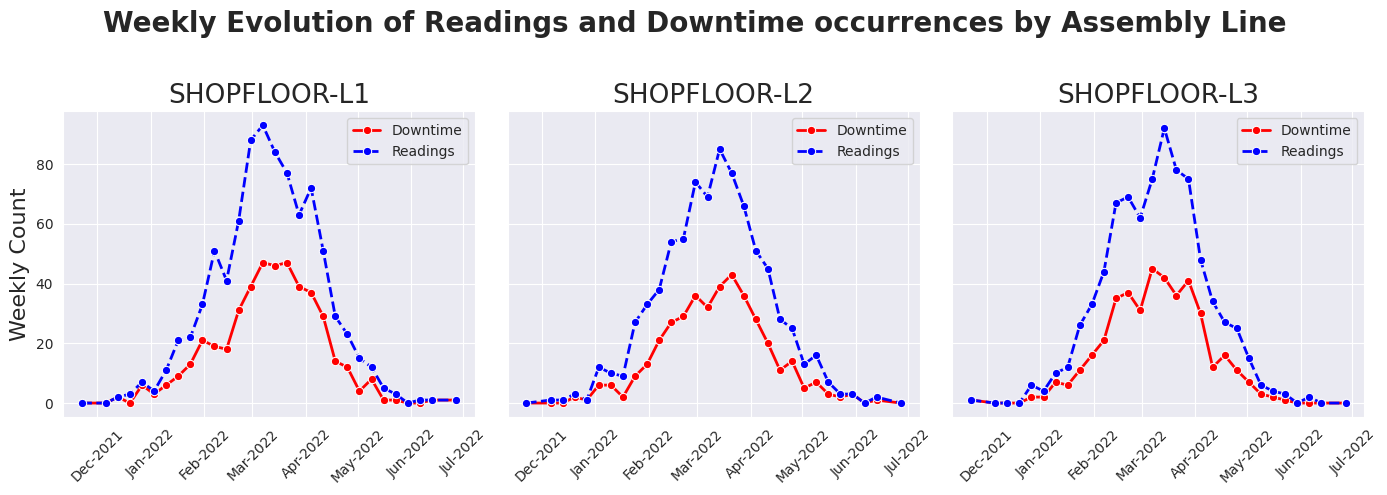

In [ ]:


# Add a 'Week' column to the dataframe
df['Week'] = df['Date'].dt.to_period('W')
df['Week'] = df['Week'].dt.start_time

# Count measurements per assembly line per week
weekly_assembly_line_count = df.groupby(['Week', 'Assembly_Line_No']).size().reset_index(name='entry_count')

# Count downtimes per assembly line per week
downtime_by_assembly_line_weekly = df.groupby(['Week', 'Assembly_Line_No'])['Downtime'].sum().reset_index(name='Downtime_occurrences')

# Create a plot with 3 subplots (for 3 assembly lines)
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14, 5))

# Choose the first 3 assembly lines to plot
assembly_lines = downtime_by_assembly_line_weekly['Assembly_Line_No'].unique()[:3]

# Plot downtime evolution for each assembly line
for i, assembly_line in enumerate(assembly_lines):
    ax = axes[i]
    data = downtime_by_assembly_line_weekly[downtime_by_assembly_line_weekly['Assembly_Line_No'] == assembly_line]

    # Plot downtime occurrences with a red line and 95% confidence interval
    sns.lineplot(data=data, x='Week', y='Downtime_occurrences', ax=ax, color='red', ci=95, marker='o', lw=2, label="Downtime")

    # Plot number of readings with a dashed blue line
    sns.lineplot(data=weekly_assembly_line_count[weekly_assembly_line_count['Assembly_Line_No'] == assembly_line], x='Week', y='entry_count', color='blue', ax=ax, linestyle='--', marker='o', lw=2, label="Readings")

    ax.set_title(f'{assembly_line}'.upper(), fontsize=19)
    ax.set_xlabel('')
    ax.set_ylabel('Weekly Count', fontsize=16)
    ax.tick_params(axis='x', rotation=45)

    # Format x-axis to show month-year labels
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Add a main title for the entire figure
fig.suptitle(f"Weekly Evolution of Readings and Downtime occurrences by Assembly Line", weight='bold', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Almost every week, there was at least one downtime occurrence, with only two weeks having no downtimes. These were the second week of December 2021 and the 28th week of June 2022.

In [ ]:


# Assuming 'df' is your DataFrame with 'Date' and 'Downtime' columns

# Create columns for week number, day of the week, and month-year
df['Week_Of_Year'] = df['Date'].dt.isocalendar().week
df['Day_Of_Week'] = df['Date'].dt.dayofweek
df['Month_Year'] = df['Date'].dt.strftime('%b-%Y')  # Format as "Jan-2022", "Feb-2022", etc.
df['Month'] = df['Date'].dt.strftime('%m')
df['Year'] = df['Date'].dt.strftime('%Y')

# Map the weeks to ordinal_week
unique_weeks = df[['Date', 'Week_Of_Year']].drop_duplicates().sort_values('Date')
week_mapping = {week: idx + 1 for idx, week in enumerate(unique_weeks['Week_Of_Year'].unique())}
df['Ordinal_Week'] = df['Week_Of_Year'].map(week_mapping)

# Labels for days of the week
dayofweek_labels = dict(zip(list(range(0,7)), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))

# Filter out rows where downtime occurred
counts_df = df[df['Downtime'] == 1].drop_duplicates(subset='Date', keep='first')
counts_df['Day_Of_Week'] = counts_df['Day_Of_Week'].replace(dayofweek_labels)

# Count weeks with downtime occurrences
weeks_downtime = counts_df.groupby('Week_Of_Year')['Downtime'].count().reset_index(name='Days with Any Downtime Occurrences')

# Calculate total weeks with downtime and total weeks in the dataset
total_weeks_downtime = len(weeks_downtime[weeks_downtime['Days with Any Downtime Occurrences'] > 0])
dataset_num_weeks = df['Week_Of_Year'].nunique()
percent_weeks_downtime = round((total_weeks_downtime/dataset_num_weeks)*100, 2)

# Calculate weeks without downtime
weeks_without_downtime = int(dataset_num_weeks - round((percent_weeks_downtime * dataset_num_weeks)/100, 0))
print(f"\nTotal of {percent_weeks_downtime}% of the weeks with occurrences of downtime (only {weeks_without_downtime} weeks without any downtime).\n")

# Find weeks with no downtime occurrences
weeks_with_downtime = set(weeks_downtime['Week_Of_Year'].values)
weeks_df = set(df['Week_Of_Year'].values)
no_downtime_weeks = list(weeks_df.difference(weeks_with_downtime))

print("ORDINAL WEEKS WITH NO DOWNTIME OCCURRENCES:")
# Display the weeks with no downtime occurrences
print(df[df['Week_Of_Year'].isin(no_downtime_weeks)][['Date', 'Ordinal_Week']].drop_duplicates(subset=['Date'], keep='first').sort_values(by='Date'))



Total of 93.33% of the weeks with occurrences of downtime (only 2 weeks without any downtime).

ORDINAL WEEKS WITH NO DOWNTIME OCCURRENCES:
           Date  Ordinal_Week
1823 2021-12-08             2
1981 2022-06-06            28
1895 2022-06-07            28
1755 2022-06-09            28


In [ ]:
# Assembly lines with 100% downtime stats

# Calculate the downtime rate per date
downtime_per_date = df.groupby(['Machine_ID', 'Date'])['Downtime'].mean().mul(100).round(2).reset_index()
downtime_per_date['day'] = downtime_per_date['Date'].dt.day_name()

#full_downtime = downtime_rate_by_assembly_line_daily[downtime_rate_by_assembly_line_daily['Downtime_rate'] ==100].sort_values('Date')
full_downtime = downtime_per_date[downtime_per_date['Downtime'] == 100].sort_values('Date')

print(f"Number of days with one or more machines with 100% downtime rate: {full_downtime['Date'].nunique()} days.")
print(f"Number of assembly lines with 100% downtime rate at the same day: {full_downtime.groupby('Date')['Machine_ID'].count().max()} machines/assembly lines.")

# Number of 100% Downtime Occurrences
full_downtime.groupby(['Machine_ID'])['Downtime'].count().rename('Number of 100% Downtime Occurrences')

Number of days with one or more machines with 100% downtime rate: 48 days.
Number of assembly lines with 100% downtime rate at the same day: 2 machines/assembly lines.


/tmp/ipykernel_31/1098143348.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  downtime_per_date = df.groupby(['Machine_ID', 'Date'])['Downtime'].mean().mul(100).round(2).reset_index()
/tmp/ipykernel_31/1098143348.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  full_downtime.groupby(['Machine_ID'])['Downtime'].count().rename('Number of 100% Downtime Occurrences')


Machine_ID
Makino-L1-Unit1-2013    22
Makino-L2-Unit1-2015    17
Makino-L3-Unit1-2015    19
Name: Number of 100% Downtime Occurrences, dtype: int64

There were 48 days with 100% downtime, but these days had fewer readings, indicating possible data bias. Downtime was limited to one or two assembly lines at a time. The machines with the most 100% downtime were:

Makino-L1-Unit1-2013 (22 days)

Makino-L3-Unit1-2015 (19 days)

Makino-L2-Unit1-2015 (17 days)

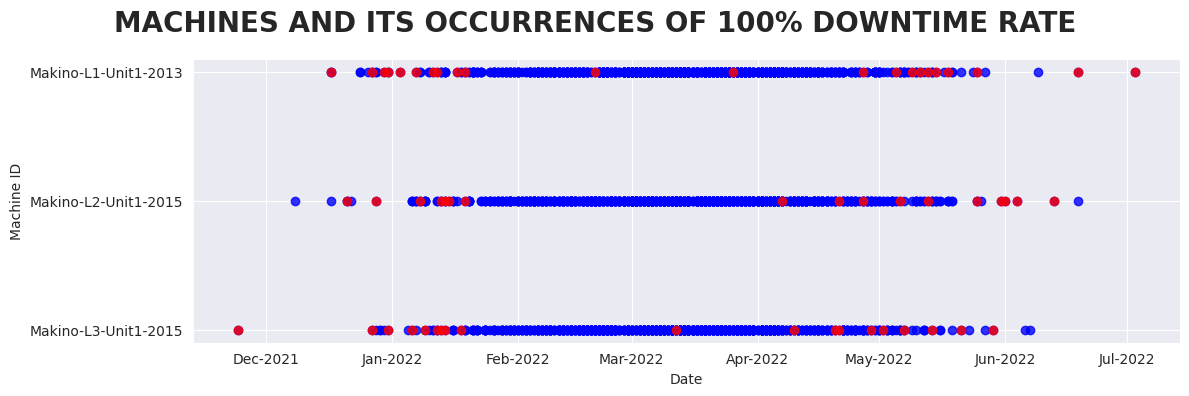

In [ ]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))

# Set to track machines that have already been plotted
plotted_labels = set()

# Loop through each unique machine ID
for machineID in df['Machine_ID'].unique():
    data = df[df['Machine_ID'] == machineID].sort_values('Date')

    # Scatter plot for the current machine's data
    ax.scatter(
        data['Date'],
        [machineID] * len(data),
        color='blue',  # Replace with desired color
        alpha=0.8,
        label=machineID if machineID not in plotted_labels else None
    )
    plotted_labels.add(machineID)

    # Plot missing data (Downtime)
    machine_full_downtime = full_downtime[full_downtime['Machine_ID'] == machineID]
    ax.scatter(
        machine_full_downtime['Date'],
        [machineID] * len(machine_full_downtime),
        color='red',  # Replace with desired color for downtime
        alpha=0.8
    )

# Formatting the plot
ax.set_xlabel('Date')
ax.set_ylabel('Machine ID')

# Format x-axis with month-year labels
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Set title
fig.suptitle("Machines and its Occurrences of 100% Downtime Rate".upper(), weight='bold', fontsize=20)

plt.tight_layout()
plt.show()

Downtime occurred on every day of the week.

Saturdays had the highest downtime occurrence, meaning downtime was recorded on all Saturdays.

Wednesdays had the lowest downtime occurrence, with downtime happening only about 84% of the time.

In [ ]:
# Count of total number of days in the whole period
count_days = df.drop_duplicates(subset='Date', keep='first')['Day_Of_Week'].replace(dayofweek_labels).value_counts().reset_index(name='Total days')

downtime_counts = counts_df.groupby('Day_Of_Week')['Downtime'].count().reset_index(name='Days with Any Downtime Occurrences')
downtime_counts = downtime_counts.merge(count_days, on='Day_Of_Week')
downtime_counts['% Downtime Days'] =  round((downtime_counts['Days with Any Downtime Occurrences'] / downtime_counts['Total days'] )*100, 2)
downtime_counts.sort_values(by='% Downtime Days', ascending=False)

,Day_Of_Week,Days with Any Downtime Occurrences,Total days,% Downtime Days
2,Saturday,21,21,100.00
1,Monday,22,24,91.67
0,Friday,21,23,91.30
3,Sunday,21,23,91.30
4,Thursday,21,23,91.30
5,Tuesday,21,24,87.50
6,Wednesday,22,26,84.62


**Downtime Range**: Downtime varied from 0% to 100% across machines, with Makino-L2-Unit1-2015 reaching 66.67% on Sundays.

**Median**: The median downtime was around 50%, indicating frequent downtime.

**Makino-L1-Unit1-2013**: Had the highest downtime rates, especially on Wednesdays, with the worst downtime at 100%.

**Makino-L2-Unit1-2015 and Makino-L3-Unit1-2015**: Showed mostly lower downtime rates, but higher on Wednesdays and Saturdays.

## Stability:

Makino-L1 was stable on Tuesdays and Thursdays.

Makino-L2 had low downtime on Sundays and Mondays.

Makino-L3 was stable on Mondays and Tuesdays.

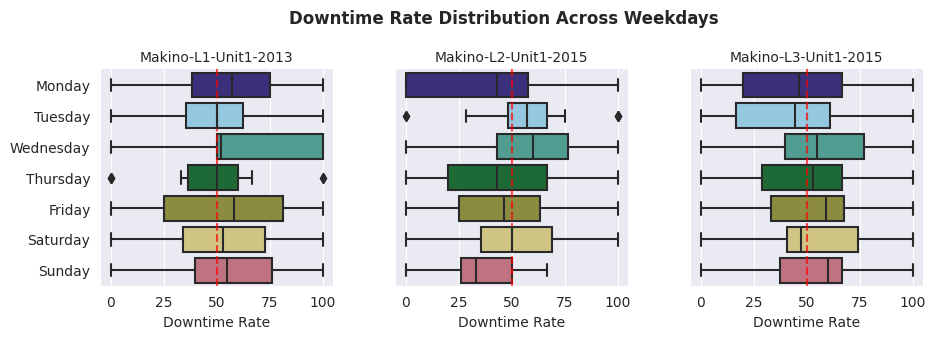

In [ ]:


# Define weekday order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a grid of boxplots for each machine
g = sns.FacetGrid(downtime_per_date, col="Machine_ID", col_wrap=3, sharex=True, sharey=True)

# Loop through each machine and create a boxplot
for machine_id, ax in zip(g.col_names, g.axes.flat):
    sns.boxplot(
        data=downtime_per_date[downtime_per_date["Machine_ID"] == machine_id],
        x="Downtime", y="day", order=weekday_order, ax=ax
    )
    ax.axvline(50, linestyle="--", color='red', alpha=0.7)  # 50% reference line

# Set axis labels and titles
g.set_axis_labels("Downtime Rate", "")
g.set_titles("{col_name}")
g.set(yticks=range(len(weekday_order)), yticklabels=weekday_order)

# Title for the whole figure
g.fig.suptitle("Downtime Rate Distribution Across Weekdays", weight='bold', fontsize=12, y=1.05)

# Adjust spacing to prevent overlap
plt.subplots_adjust(top=0.85)
plt.show()


All machines had stable downtime around 50%, but this could be due to increased readings and frequency early on.

Wider confidence intervals at the start and end suggest variability from data gaps and fewer readings.

Makino-L1-Unit1-2013 & Makino-L3-Unit1-2015 showed improvement, while Makino-L2-Unit1-2015 saw a worsening trend with higher downtime rates.

/tmp/ipykernel_31/311273622.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  downtime_per_date = df.groupby(['Machine_ID', 'Date'])['Downtime'].mean().mul(100).round(2).reset_index().dropna(subset='Downtime')
/tmp/ipykernel_31/311273622.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  downtime_per_date['rolling_avg'] = downtime_per_date.groupby('Machine_ID')['Downtime'].transform(lambda x: x.rolling(7, min_periods=1).mean())
/tmp/ipykernel_31/311273622.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain

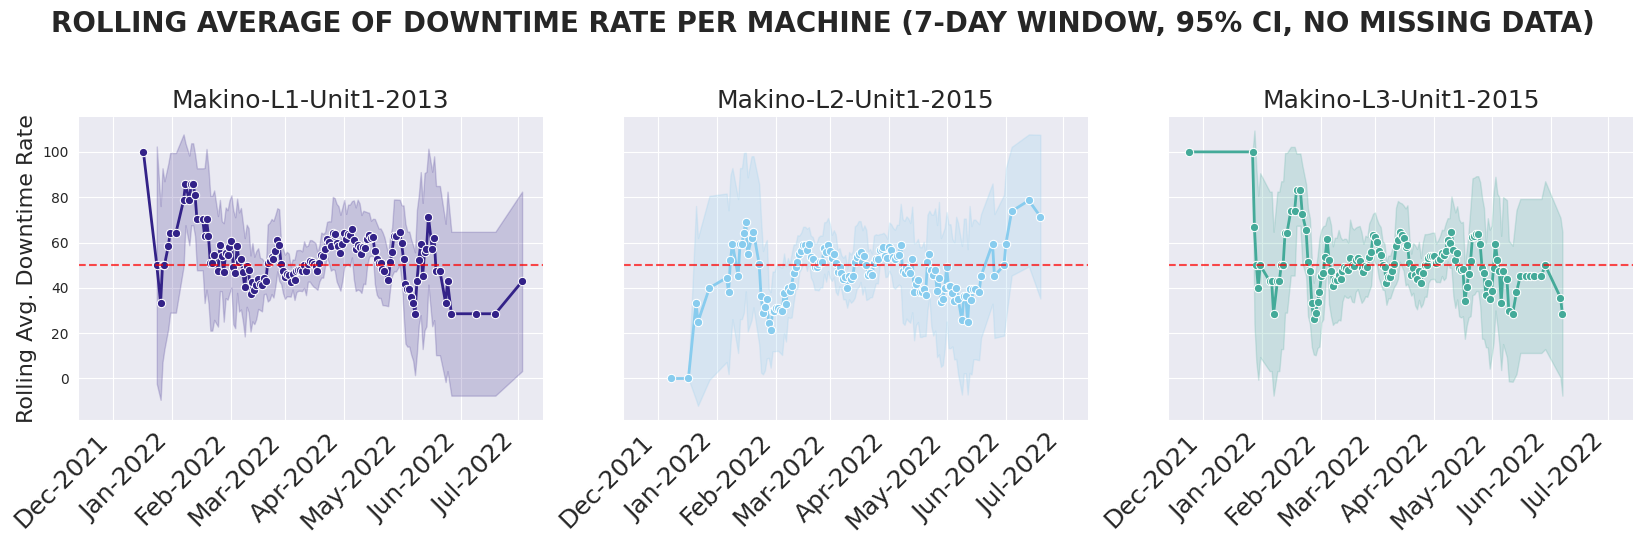

In [ ]:
# Downtime rate per week: 7-day rolling mean per machine
downtime_per_date = df.groupby(['Machine_ID', 'Date'])['Downtime'].mean().mul(100).round(2).reset_index().dropna(subset='Downtime')

# Calculate rolling mean and standard deviation for a smoother trend
downtime_per_date['rolling_avg'] = downtime_per_date.groupby('Machine_ID')['Downtime'].transform(lambda x: x.rolling(7, min_periods=1).mean())
downtime_per_date['rolling_std'] = downtime_per_date.groupby('Machine_ID')['Downtime'].transform(lambda x: x.rolling(7, min_periods=1).std())

# Calculate confidence intervals (mean ± 1.96 * std / sqrt(n))
downtime_per_date['ci_lower'] = downtime_per_date['rolling_avg'] - (1.96 * downtime_per_date['rolling_std'] / np.sqrt(7))
downtime_per_date['ci_upper'] = downtime_per_date['rolling_avg'] + (1.96 * downtime_per_date['rolling_std'] / np.sqrt(7))

# FacetGrid for each machine
g = sns.FacetGrid(data=downtime_per_date, col='Machine_ID', col_wrap=3, height=5.5, aspect=1.0, sharey=True)

# Plot the rolling mean, confidence interval, and guide line
def plot_ci(x, y, **kwargs):
    ax = plt.gca()
    sub_df = kwargs['data']
    machine_id = sub_df['Machine_ID'].iloc[0]  # Get the machine ID
    color = machine_color_map.get(machine_id, 'gray')  # Default to gray if not in dict

    # Confidence interval shading
    ax.fill_between(sub_df[x], sub_df['ci_lower'], sub_df['ci_upper'], alpha=0.2, color=color)

    # Rolling mean line
    sns.lineplot(data=sub_df, x=x, y=y, ax=ax, linestyle='solid', marker='o', lw=2, color=color)

    # Guide line at 50%
    ax.axhline(y=50, linestyle="--", color="red", alpha=0.7)  # Dotted red line at 50%

g.map_dataframe(plot_ci, 'Date', 'rolling_avg')

# Adjust x-axis format
for ax in g.axes.flatten():
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

# Titles and labels
g.set_axis_labels('', 'Rolling Avg. Downtime Rate', fontsize=16)
g.set_titles(col_template="{col_name}", size=18)
g.set_xticklabels(rotation=45, horizontalalignment='right', fontsize=18)
g.fig.suptitle("Rolling Average of Downtime Rate Per Machine (7-Day Window, 95% CI, No Missing Data)\n".upper(), weight='bold', fontsize=20)


plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.show()

Makino-L1-Unit1-2013 had the highest downtime rate at 54%.

Makino-L3-Unit1-2015 had the second highest downtime rate at 51%.

Makino-L2-Unit1-2015 had the lowest downtime rate at 46%.

In [ ]:
# Distribution of overall Downtime rates per date by machine
print("Distribution of overall Downtime rates per date by machine: ".upper())
downtime_per_date.groupby('Machine_ID')['Downtime'].describe()

DISTRIBUTION OF OVERALL DOWNTIME RATES PER DATE BY MACHINE: 


/tmp/ipykernel_31/828936450.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  downtime_per_date.groupby('Machine_ID')['Downtime'].describe()


,count,mean,std,min,25%,50%,75%,max
Machine_ID,,,,,,,,
Makino-L1-Unit1-2013,141.0,53.668014,29.322515,0.0,36.36,50.0,71.43,100.0
Makino-L2-Unit1-2015,139.0,47.360288,30.530772,0.0,27.92,50.0,66.67,100.0
Makino-L3-Unit1-2015,136.0,49.797941,30.894651,0.0,30.00,50.0,66.67,100.0


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


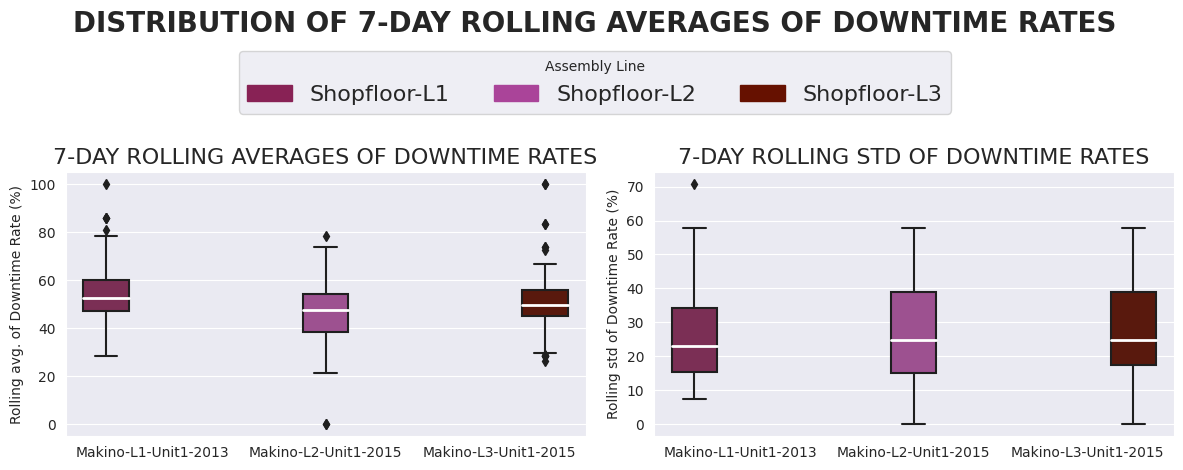

In [ ]:
# Distribution of 7-day rolling averages of Downtime rates by machine

# Create subplots
fig, axes = plt.subplots(1, 2, sharey=False,figsize=(12, 5))

# Subplot 1: Timeline evolution
ax = axes[0]
sns.boxplot(
    data=downtime_per_date,
    x='Machine_ID',
    y='rolling_avg',
    hue='Machine_ID',
    palette=machine_downtime_color_map,
    #legend=False,
    medianprops={'color': 'white', 'linewidth': 2},  # Make the median line white and adjust its thickness
    ax=ax
)
ax.set_title(f"7-day rolling averages of downtime rates".upper(), fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Rolling avg. of Downtime Rate (%)')
ax.legend_.remove()  # Remove the legend explicitly

#ax.tick_params(axis='x', rotation=45)

# Subplot 2:  std
ax = axes[1]
sns.boxplot(
    data=downtime_per_date,
    x='Machine_ID',
    y='rolling_std',
    hue='Machine_ID',
    palette=machine_downtime_color_map,
    #legend=False,
    medianprops={'color': 'white', 'linewidth': 2},  # Make the median line white and adjust its thickness
    ax=ax
)
ax.set_title(f"7-day rolling std of downtime rates".upper(), fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Rolling std of Downtime Rate (%)')
ax.legend_.remove()  # Remove the legend explicitly
#ax.tick_params(axis='x', rotation=45)

# Add a shared legend
# Create a legend using the assembly_line_color_map
legend_patches = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=key)
    for key, color in assembly_line_downtime_color_map.items()
]

# Place the legend below the subplots
fig.legend(
    handles=legend_patches,
    title='Assembly Line',
    loc='lower center',
    bbox_to_anchor=(0.5, 0.75),
    ncol=3,
    frameon=True,
    fontsize=16
)

# Add an overall title
fig.suptitle(f"Distribution of 7-day rolling averages of downtime rates\n\n".upper(), weight='bold', fontsize=20)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


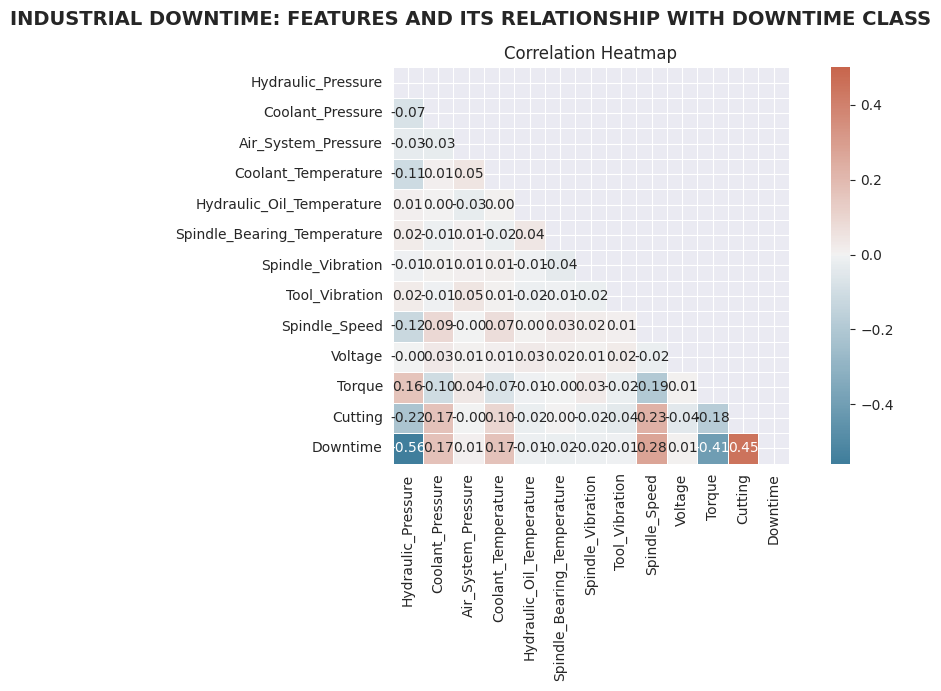

In [ ]:
# Analyse the correlation with the class
corr_matrix = df[np.concatenate([numerical_col,['Downtime']])].corr(numeric_only=True)
np.fill_diagonal(corr_matrix.values, 0)  # Fill the diagonal with zeros
filtered_corr = corr_matrix[(abs(corr_matrix) > 0.15) & (corr_matrix != 1.0)]
filtered_corr = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create a one-column subplot
fig, ax = plt.subplots(figsize=(10, 7))  # Adjust the size as needed

# Plot the heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap=cmap, vmax=0.5, center=0, square=True, linewidths=0.5, ax=ax)

# Add titles
plt.suptitle("INDUSTRIAL DOWNTIME: FEATURES AND ITS RELATIONSHIP WITH DOWNTIME CLASS", weight='bold', fontsize=14)
plt.title('Correlation Heatmap', fontsize=12)

# Show the plot
plt.tight_layout()#(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid overlap
plt.show()

Hydraulic Pressure and Torque: Moderate inverse correlation with downtime (-0.56, -0.41); lower values increase downtime.

Cutting Force: Moderate positive correlation with downtime (0.45); higher force leads to more downtime.

Spindle Speed: Weak positive correlation with downtime (0.27); higher speeds increase downtime.

Cutting Force and Spindle Speed: Weak positive correlation (0.23).

Cutting Force and Hydraulic Pressure: Weak inverse correlation (-0.22).

In [ ]:
# Correlations
from scipy.stats import skew, pearsonr, pointbiserialr, chi2_contingency, fisher_exact

def phi_coefficient(x, y):
    cm = pd.crosstab(x, y)
    if cm.shape == (2, 2):
        return (cm.iloc[0, 0] * cm.iloc[1, 1] - cm.iloc[0, 1] * cm.iloc[1, 0]) / np.sqrt(
            (cm.iloc[0, 0] + cm.iloc[0, 1]) *
            (cm.iloc[0, 0] + cm.iloc[1, 0]) *
            (cm.iloc[1, 1] + cm.iloc[0, 1]) *
            (cm.iloc[1, 1] + cm.iloc[1, 0])
        )
    return None

In [ ]:
from scipy.stats import pearsonr, pointbiserialr, chi2_contingency

def get_correlation_stats(data, col1, col2, significance_level=0.05):
    def is_binary_col(col):
        return pd.api.types.is_numeric_dtype(col) and col.nunique() == 2

    if is_binary_col(data[col1]) and is_binary_col(data[col2]):
        stat = phi_coefficient(data[col1], data[col2])
        p_value, test_name = None, "Phi Coefficient"

    elif is_binary_col(data[col2]) and pd.api.types.is_numeric_dtype(data[col1].dtype):
        stat, p_value = pointbiserialr(data[col2], data[col1].astype(int))
        test_name = "Point-Biserial Correlation"

    elif is_binary_col(data[col1]) and pd.api.types.is_numeric_dtype(data[col2].dtype):
        stat, p_value = pointbiserialr(data[col1], data[col2].astype(int))
        test_name = "Point-Biserial Correlation"

    elif pd.api.types.is_categorical_dtype(data[col1]) or pd.api.types.is_categorical_dtype(data[col2]):
        contingency_table = pd.crosstab(data[col1], data[col2])
        stat, p_value, _, _ = chi2_contingency(contingency_table)
        test_name = "Chi-Square Test"

    elif pd.api.types.is_numeric_dtype(data[col1].dtype) and pd.api.types.is_numeric_dtype(data[col2].dtype):
        stat, p_value = pearsonr(data[col1], data[col2])
        test_name = "Pearson Correlation"

    else:
        stat, p_value, test_name = None, None, None

    is_significant = p_value is None or p_value < significance_level
    return stat, p_value, test_name, is_significant


In [ ]:
def get_correlations(data, column1, column2):
    stat, p_value, test_name, is_significant = get_correlation_stats(data, column1, column2, significance_level=0.05)
    results = []
    results.append({'Feature': column1, 'Target': column2, 'Type': test_name, 'is_siginificant':is_significant, 'Test Value': stat, 'P-Value': p_value})
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
final_results = pd.DataFrame()
final_results = pd.concat([final_results, get_correlations(df.dropna(), 'Downtime', 'Hydraulic_Pressure')], ignore_index=True)
final_results = pd.concat([final_results, get_correlations(df.dropna(), 'Downtime', 'Cutting')], ignore_index=True)
final_results = pd.concat([final_results, get_correlations(df.dropna(), 'Downtime', 'Torque')], ignore_index=True)
final_results = pd.concat([final_results, get_correlations(df.dropna(), 'Downtime', 'Spindle_Speed')], ignore_index=True)
final_results = pd.concat([final_results, get_correlations(df.dropna(), 'Cutting', 'Spindle_Speed')], ignore_index=True)
final_results = pd.concat([final_results, get_correlations(df.dropna(), 'Cutting', 'Hydraulic_Pressure')], ignore_index=True)
final_results

/tmp/ipykernel_31/923817913.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_categorical_dtype(data[col1]) or pd.api.types.is_categorical_dtype(data[col2]):


,Feature,Target,Type,is_siginificant,Test Value,P-Value
0,Downtime,Hydraulic_Pressure,Point-Biserial Correlation,True,-0.552758,1.284848e-190
1,Downtime,Cutting,Point-Biserial Correlation,True,0.383990,1.661696e-84
2,Downtime,Torque,Point-Biserial Correlation,True,-0.406751,1.491058e-95
3,Downtime,Spindle_Speed,Point-Biserial Correlation,True,0.273018,5.733500e-42
4,Cutting,Spindle_Speed,Pearson Correlation,True,0.231764,2.107786e-30
5,Cutting,Hydraulic_Pressure,Pearson Correlation,True,-0.217178,8.207222e-27


/tmp/ipykernel_31/466817456.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x=column, hue='Downtime', shade=True, legend=False, palette=downtime_palette, ax=axes[i])
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/tmp/ipykernel_31/466817456.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This

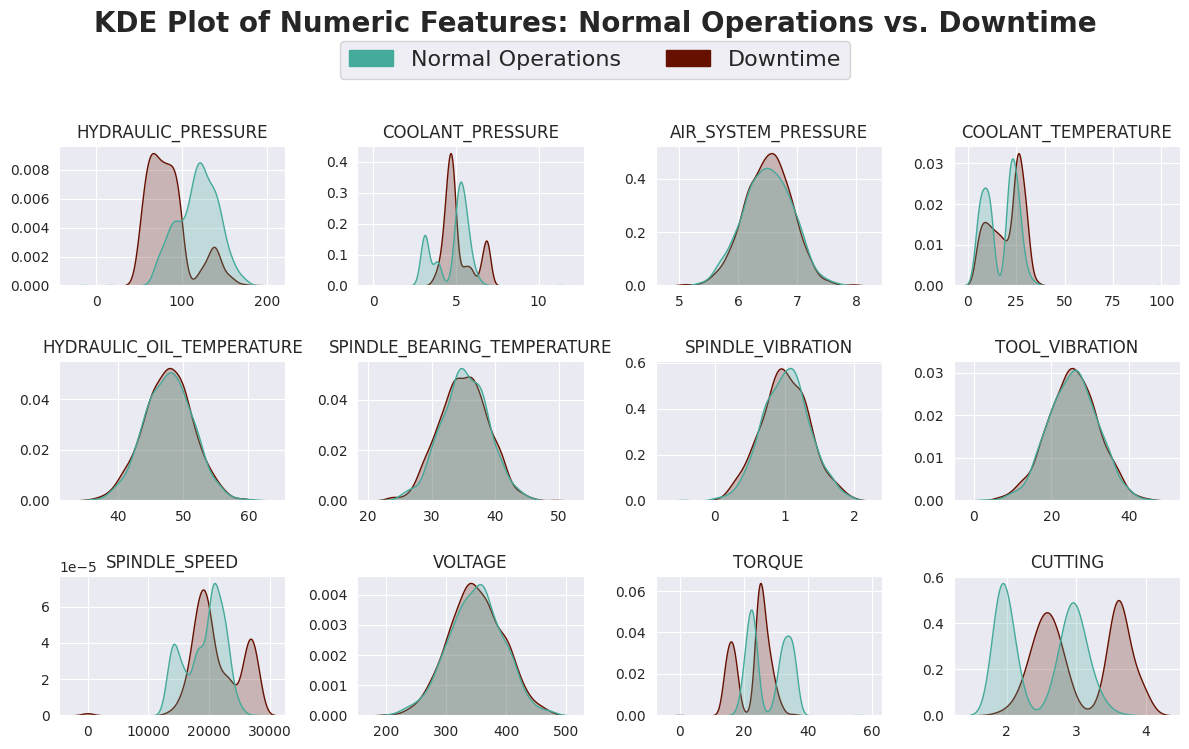

In [ ]:


# Define color palette for downtime
downtime_palette = {0: palette[2], 1: palette[9]}

# Set up number of rows and columns for subplots
n_cols = 4
n_rows = math.ceil(len(numerical_col) / n_cols)  # Calculate required rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8), sharey=False)
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each numerical column and plot
for i, column in enumerate(numerical_col):
    sns.kdeplot(data=df, x=column, hue='Downtime', shade=True, legend=False, palette=downtime_palette, ax=axes[i])
    axes[i].set_title(f'{column}'.upper())
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')

# Hide empty subplots if any
for i in range(len(numerical_col), len(axes)):
    fig.delaxes(axes[i])

# Add a shared legend
legend_dict = {"Normal Operations": palette[2], "Downtime": palette[9]}
legend_patches = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=key)
    for key, color in legend_dict.items()
]
fig.legend(
    handles=legend_patches,
    title='',
    loc='lower center',
    bbox_to_anchor=(0.5, 0.88),
    ncol=2,
    frameon=True,
    fontsize=16
)

# Add main title and adjust layout
fig.suptitle('KDE Plot of Numeric Features: Normal Operations vs. Downtime\n', fontsize=20, weight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


No Clear Distinction: Features like Air_System_Pressure, Hydraulic_Oil_Temperature, and Spindle_Vibration show similar distributions for both normal and failure states, not helpful for downtime prediction.

Distinct Patterns: Features such as Hydraulic_Pressure, Coolant_Pressure, and Cutting show noticeable differences between normal and downtime states, with bimodal distributions, making them valuable for predicting downtime.

In [ ]:
# Placeholder function for confidence interval calculation
def calc_upper_lower_whiskers(df, col, confidence=0.95):
    """Calculate confidence interval for a given numerical column."""
    mean = df[col].mean()
    std_err = df[col].std() / np.sqrt(len(df))
    margin = 1.96 * std_err  # Approximate 95% CI
    return (mean - margin, mean + margin)

# Filtering Normal Operation (Downtime == 0) and Downtime cases (Downtime == 1)
normal_op = df[df['Downtime'] == 0]
downtime_op = df[df['Downtime'] == 1]

results = []

# Loop through numerical features
for column in numerical_col:
    for downtime_status, subset in [('Normal', normal_op), ('Downtime', downtime_op)]:
        ci_min = []
        ci_max = []

        # Compute CI for each machine
        for machine in df['Machine_ID'].unique():
            machine_data = subset[subset['Machine_ID'] == machine]
            if not machine_data.empty:
                lower, upper = calc_upper_lower_whiskers(machine_data, column)
                ci_min.append(lower)
                ci_max.append(upper)

        # Compute standard deviation of min/max confidence interval bounds
        std_min = np.std(ci_min) if len(ci_min) > 1 else np.nan
        std_max = np.std(ci_max) if len(ci_max) > 1 else np.nan

        results.append([column, downtime_status, std_min, std_max])

print("standard deviation of CI bounds across machines and operational status greater than 1 unit: ".upper())
std_df = pd.DataFrame(results, columns=["Feature", "Downtime Status", "Std of CI Min", "Std of CI Max"])
std_df[std_df['Std of CI Min'] > 1]

STANDARD DEVIATION OF CI BOUNDS ACROSS MACHINES AND OPERATIONAL STATUS GREATER THAN 1 UNIT: 


,Feature,Downtime Status,Std of CI Min,Std of CI Max
0,Hydraulic_Pressure,Normal,1.311267,1.356009
16,Spindle_Speed,Normal,26.501543,29.309653
17,Spindle_Speed,Downtime,144.133086,115.359998
18,Voltage,Normal,2.628182,2.492270


The operational consistency across machines is generally high, with confidence interval variations being less than 1 unit for most features. The only exceptions are:

Hydraulic Pressure (up to 1.36 bar)

Voltage (up to 2.64 volts)

Spindle Speed (up to 144 RPM)

**Hydraulic Pressure:** Significant differences between normal operations and downtime were found, with lower hydraulic pressure leading to downtime. The Mann-Whitney U test showed a large effect size of 0.65. During normal operations, the average pressure is 118.6 bars, while during downtime, it drops to 84.8 bars.

**Coolant Pressure:** No significant differences were observed, with overlapping interquartile ranges. Extremely high values (11.4 bars) suggest measurement errors, while low values during downtime (0.32 bar) indicate potential pressure loss. The average is 4.8 bars during normal operations and increases slightly to 5.11 bars during downtime.

**Air System Pressure:** There were no significant differences, with average and median values remaining consistent at 6.5 bars in both normal operations and downtime

/tmp/ipykernel_31/411101164.py:36: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.05, 1, 0.95])


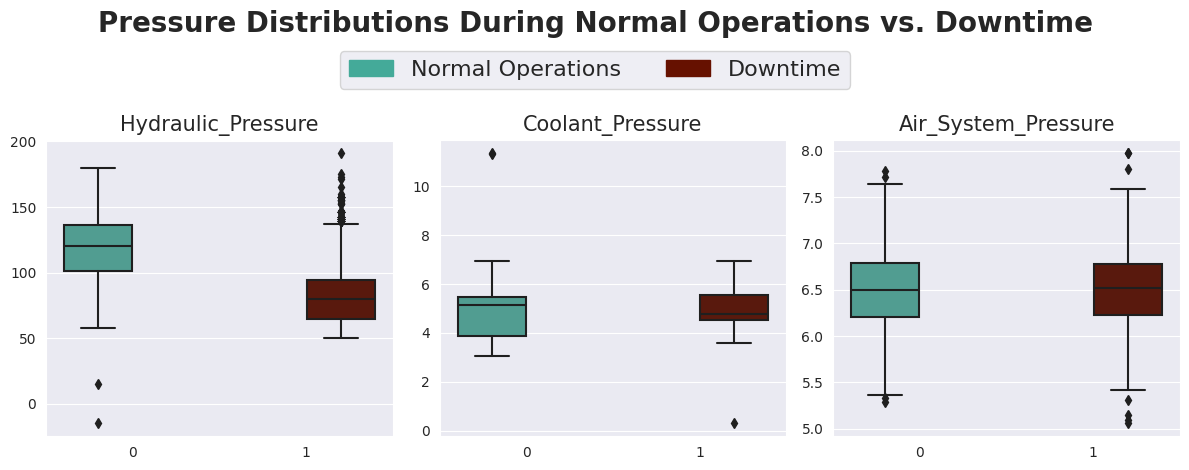

In [ ]:

# Select numerical columns (adjust to the first 12 features)
numerical_col = df.select_dtypes(include='number').columns[:12]

# Define Downtime color palette
downtime_palette = {0: palette[2], 1: palette[9]}

# Create subplots (1 row, 3 columns, adjustable)
rows, cols = 1, 3
fig, axes = plt.subplots(rows, cols, sharey=False, figsize=(12, 5), constrained_layout=True)
axes = axes.flatten()

# Loop through the first 3 numerical columns and create boxplots
for i, col in enumerate(numerical_col[0:3]):
    sns.boxplot(data=df, x='Downtime', y=col, ax=axes[i], hue='Downtime', palette=downtime_palette)
    axes[i].set_title(col, fontsize=15)
    axes[i].set_ylabel('')  # Remove y-axis label
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].legend_.remove()  # Remove legend

# Hide any unused subplots
for i in range(len(numerical_col), len(axes)):
    axes[i].axis('off')

# Add a shared legend
legend_dict = {"Normal Operations": palette[2], "Downtime": palette[9]}
legend_patches = [plt.Rectangle((0, 0), 1, 1, color=color, label=key) for key, color in legend_dict.items()]
fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.8), ncol=2, frameon=True, fontsize=16)

# Set the main title
fig.suptitle('Pressure Distributions During Normal Operations vs. Downtime\n', fontsize=20, weight='bold')

# Show the plot
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [ ]:

# Function to test normality for each group
def test_normality(data, group_col, target_feature, min_group_size=3):
    results = {}
    for group in data[group_col].unique():
        group_data = data[data[group_col] == group][target_feature]

        # Check if the group has at least the minimum required size
        if len(group_data) < min_group_size:
            results[group] = 10 #"Insufficient data (< 3 observations)"
        else:
            # Perform Shapiro-Wilk test
            p_value = shapiro(group_data).pvalue
            results[group] = p_value

    return results

# Function to test homogeneity of variance
def test_variance_homogeneity(data, group_col, target_feature, min_group_size=2, significance_level=0.05):
    # Extract groups
    groups = [data[data[group_col] == group][target_feature] for group in data[group_col].unique()]

    # Check if all groups have at least the minimum size
    small_groups = [group for group in groups if len(group) < min_group_size]

    if small_groups:
        print(f"Warning: {len(small_groups)} group(s) have fewer than {min_group_size} observations. Assuming heterogeneity.")
        return False

    # Perform Levene's test
    p_value = levene(*groups).pvalue
    #print(f"Levene's test p-value: {p_value}")
    return p_value > significance_level

def get_cleaned_groups(data, group_col, target_col, group1, group2, min_size=1):
    """
    Cleans and prepares groups for statistical testing.

    Parameters:
    - data (pd.DataFrame): The dataset containing the data.
    - group_col (str): The column used to group data.
    - target_col (str): The target column for statistical testing.
    - group1, group2: The values of the group_col to extract.
    - min_size (int): Minimum required size for each group.

    Returns:
    - grp1_cleaned, grp2_cleaned: Cleaned groups as Pandas Series.
    - is_valid (bool): Whether both groups are valid for testing.
    - message (str): Information about the cleaning or issues.
    """
    # Extract groups and drop NaN values
    grp1 = data[data[group_col] == group1][target_col].dropna()
    grp2 = data[data[group_col] == group2][target_col].dropna()

    # Ensure groups are numeric
    if not pd.api.types.is_numeric_dtype(grp1) or not pd.api.types.is_numeric_dtype(grp2):
        return None, None, False, "Non-numeric data in one or both groups."

    # Check group sizes
    if len(grp1) < min_size:
        return None, None, False, f"Group '{group1}' has fewer than {min_size} observations."
    if len(grp2) < min_size:
        return None, None, False, f"Group '{group2}' has fewer than {min_size} observations."

    return grp1, grp2, True, "Groups are cleaned and valid for testing."


# Function to perform pairwise comparison based on assumptions
def perform_pairwise_test(data, group_col, target_col, group1, group2, normality_p_values, levene_p_value, significance_level=0.05):
    #grp1_data = data[data[group_col] == group1][target_col]
    #grp2_data = data[data[group_col] == group2][target_col]

    # Clean and prepare groups
    grp1_data, grp2_data, is_valid, message = get_cleaned_groups(data, group_col, target_col, group1, group2)
    if not is_valid:
        print(f"Skipping test for groups '{group1}' and '{group2}': {message}")
        return group1, group2, None, None, "Invalid Data", False

    if grp1_data.empty or grp2_data.empty or len(grp1_data) < 2 or len(grp2_data) < 2:
        return group1, group2, None, None, None, False

    if all(p > significance_level for p in normality_p_values.values()) and levene_p_value > significance_level:
        try:
            stat, p_value = ttest_ind(grp1_data, grp2_data)
            test_name = "t-test"
        except ValueError:
            stat, p_value = None, None
    else:
        try:
            stat, p_value = mannwhitneyu(grp1_data, grp2_data)
            test_name = "Mann-Whitney U test"
        except ValueError:
            stat, p_value = None, None

    is_significant = p_value < significance_level if p_value is not None else False
    return group1, group2, stat, p_value, test_name, is_significant


def pairwise_test(data, groupby_col, target, correct_multiple_comparisons=False, significance_level=0.05):
    stat= None
    p_value= None
    test_name= None
    is_significant= None

    # Test for normality within each group in the current category
    normality_results = test_normality(data, group_col=groupby_col, target_feature=target)

    # Test for homogeneity of variances across groups in the current category
    variance_homogeneity_result = test_variance_homogeneity(data, group_col=groupby_col, target_feature=target)

    # Groups to compare
    group_values = list(data[groupby_col].unique())

    # Perform the pairwise test between group1 and group2
    if (len(group_values) == 2):
        _, _, stat, p_value, test_name, is_significant = perform_pairwise_test(
            data,
            group_col=groupby_col,
            target_col = target,
            group1=group_values[0],
            group2=group_values[1],
            normality_p_values=normality_results,
            levene_p_value=variance_homogeneity_result,
            significance_level=significance_level
        )
    else:
        print(f"Warning: It must be only two groups to perform this pairwise test.")

    return stat, p_value, test_name, is_significant

def get_effect_size_mannwhitneyu(data, groupby_column, target_column):
    # Compute effect size
    groups = data[groupby_column].unique()
    if (len(groups) != 2): return np.nan
    group1 = data[data[groupby_column] == groups[0]][target_column].dropna()
    group2 = data[data[groupby_column] == groups[1]][target_column].dropna()
    sample_size1 = len(group1)
    sample_size2 = len(group2)

    n1, n2 = sample_size1, sample_size2

    # Compute U-test
    U, p = mannwhitneyu(group1,group2)

    #print (f"sample_size: {sample_size1}, {sample_size2}")
    effect_size = 1 - (2 * U) / (n1 * n2)
    return effect_size


def get_effect_size_cohen_d(data, groupby_column, target_column):
    # Ensure exactly two groups
    groups = np.sort(data[groupby_column].unique())
    if len(groups) != 2:
        return np.nan

    # Extract data for each group
    group1 = data[data[groupby_column] == groups[0]][target_column].dropna()
    group2 = data[data[groupby_column] == groups[1]][target_column].dropna()

    # Compute means and standard deviations
    mean1, mean2 = group1.mean(), group2.mean()
    std1, std2 = group1.std(), group2.std()

    # Compute pooled standard deviation
    n1, n2 = len(group1), len(group2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    # Compute Cohen's d
    cohen_d = (mean1 - mean2) / pooled_std if pooled_std != 0 else np.nan

    return cohen_d


def get_effect_size_auto(data, groupby_column, target_column, alpha=0.05):
    """
    Determines the best effect size based on normality test.
    - Uses Cohen's d if normal
    - Uses Mann-Whitney U effect size if non-normal
    """
    groups = data[groupby_column].unique()
    if len(groups) != 2:
        return np.nan, "Invalid Group Count"

    group1 = data[data[groupby_column] == groups[0]][target_column].dropna()
    group2 = data[data[groupby_column] == groups[1]][target_column].dropna()

    # Normality test (Shapiro-Wilk if n <= 5000, else Kolmogorov-Smirnov)
    test1 = stats.shapiro(group1) if len(group1) <= 5000 else stats.kstest(group1, 'norm')
    test2 = stats.shapiro(group2) if len(group2) <= 5000 else stats.kstest(group2, 'norm')

    normal1, normal2 = test1.pvalue > alpha, test2.pvalue > alpha
    is_normal = normal1 and normal2  # Both groups should be normal

    if is_normal:
        # Compute Cohen's d
        mean1, mean2 = np.mean(group1), np.mean(group2)
        std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
        pooled_std = np.sqrt(((len(group1) - 1) * std1**2 + (len(group2) - 1) * std2**2) / (len(group1) + len(group2) - 2))
        effect_size = (mean1 - mean2) / pooled_std
        return effect_size, "Cohen's d"
    else:
        # Compute Mann-Whitney U effect size
        U, _ = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        n1, n2 = len(group1), len(group2)
        effect_size = 1 - (2 * U) / (n1 * n2)
        return effect_size, "Mann-Whitney U Effect Size"

def pairwise_test_two_groups (data, groupby_column, target_column, extra_text='', correct_multiple_comparisons=False, significance_level=0.05):
    results = []
    effect_size = np.nan

    stat, p_value, test_name, is_significant = pairwise_test(data, groupby_column, target_column, correct_multiple_comparisons, significance_level=significance_level)
    effect_size, effect_size_test = get_effect_size_auto(data, groupby_column, target_column)
    results.append({'Feature': f"{extra_text}", 'Target': target_column, 'Type': test_name, 'is_siginificant':is_significant, 'Test Value': stat, 'P-Value': p_value, 'Effect Size': effect_size,'Effect Size Test': effect_size_test})

    results_df = pd.DataFrame(results)
    return results_df

#sns.palplot(palette)

In [ ]:
# Pairwise tests and Mann-Whitney U test effect size
final_results = pd.DataFrame()
for column in numerical_col[9:12]:
    parcial = pairwise_test_two_groups(df, groupby_column='Downtime', target_column=column, extra_text='Normal vs Dowtime')
    final_results = pd.concat([final_results, parcial], ignore_index=True)
final_results#.sort_values(by='is_siginificant', ascending=False)

,Feature,Target,Type,is_siginificant,Test Value,P-Value,Effect Size,Effect Size Test
0,Normal vs Dowtime,Voltage,Mann-Whitney U test,False,778171.0,9.632665e-01,0.011702,Cohen's d
1,Normal vs Dowtime,Torque,Mann-Whitney U test,True,514141.5,4.337799e-46,0.330583,Mann-Whitney U Effect Size
2,Normal vs Dowtime,Cutting,Mann-Whitney U test,True,1124503.5,1.779640e-83,-0.447713,Mann-Whitney U Effect Size


Hydraulic Pressure, Torque, Cutting Force, Spindle Speed show strong links to downtime with bimodal distributions.

Coolant Pressure has no significant difference between normal and downtime.

Measurement errors found in sensors, especially in Spindle Vibration, Tool Vibration, and Torque, likely due to machine pauses or inactive components.

In [ ]:
# Flagging potential errors and Handling missing data
df.loc[(df['Hydraulic_Pressure'] < 0), 'Hydraulic_Pressure'] = np.nan
df.loc[(df['Spindle_Vibration'] < 0), 'Spindle_Vibration'] = np.nan
df.loc[(df['Coolant_Pressure'] > 8), 'Coolant_Pressure'] = np.nan
df.loc[(df['Coolant_Temperature'] > 60), 'Coolant_Temperature'] = np.nan
df.loc[(df['Torque'] > 50), 'Torque'] = np.nan

# Fill missing data based on median values grouped by Machine and Operational status
df[numerical_col] = df.groupby(['Machine_ID', 'Downtime'])[numerical_col].transform(lambda x: x.fillna(x.median()))

df.drop(columns=[ 'Assembly_Line_No', 'Week', 'Date','Machine_ID', 'Week_Of_Year', 'Month_Year', 'Ordinal_Week', 'Month', 'Year'], inplace=True)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/tmp/ipykernel_31/1768251220.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

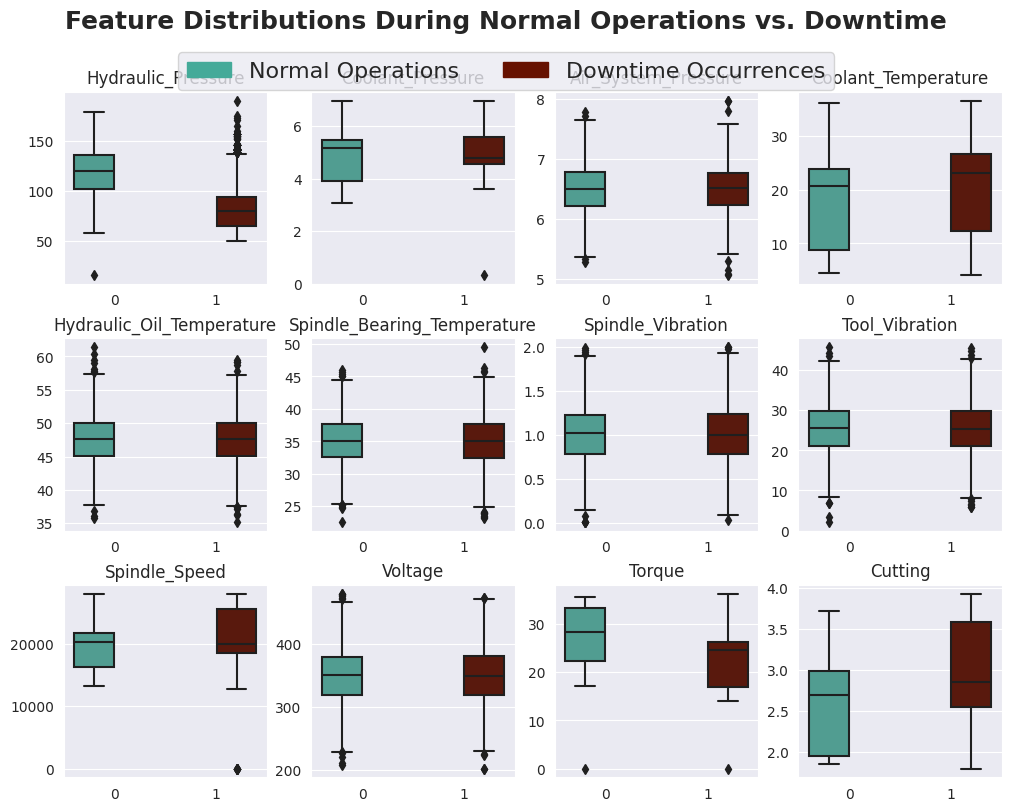

In [ ]:

# Select numerical columns
numerical_col = df.select_dtypes(include='number').columns[:12]

# Set up the subplots grid (3 rows, 4 columns)
fig, axes = plt.subplots(3, 4, figsize=(10, 8), constrained_layout=True)

# Define the color palette for Downtime vs Normal operations
downtime_palette = {0: palette[2], 1: palette[9]}

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each numerical column and create a boxplot
for i, col in enumerate(numerical_col):
    sns.boxplot(data=df, x='Downtime', y=col, ax=axes[i], hue='Downtime', palette=downtime_palette)
    axes[i].set_title(col, fontsize=12)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].legend_.remove()  # Remove legend for each subplot

# Hide unused subplots
for i in range(len(numerical_col), len(axes)):
    axes[i].axis('off')

# Add a shared legend at the bottom
legend_dict = {"Normal Operations": palette[2], "Downtime Occurrences": palette[9]}
legend_patches = [
    plt.Rectangle((0, 0), 1, 1, color=color, label=key)
    for key, color in legend_dict.items()
]

fig.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, 0.88), ncol=2, fontsize=16)

# Set the main title
fig.suptitle('Feature Distributions During Normal Operations vs. Downtime\n', fontsize=18, weight='bold')

# Display the plot
plt.show()


The model aims to minimize both false positives and false negatives, focusing on F1-score and Precision-Recall AUC (PR-AUC) as evaluation metrics. The primary models compared are:

Logistic Regression (baseline)

XGBoost Classifier (tree-based)

The dataset was split into 70% training and 30% testing, with 5-fold cross-validation for training. Features used include Hydraulic Pressure, Coolant Pressure, Spindle Speed, Torque, and others related to machine performance. Machine ID and date were excluded due to operational similarity and lack of timestamp data, respectively.

For enhanced predictive maintenance, incorporating timestamp data, time-series feature engineering, and anomaly detection is suggested for better early failure detection.

/tmp/ipykernel_31/225753900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['Downtime_cat'] = data_plot['Downtime'].replace({0: 'Normal', 1: 'Downtime'})


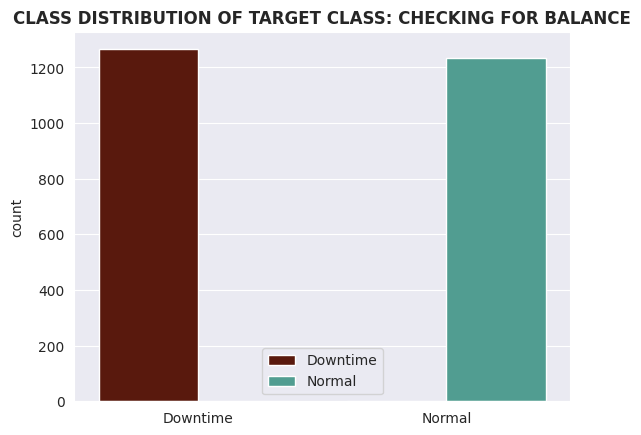

In [ ]:
# Class Distribution
downtime_palette_cat = {'Normal': '#44AA99', 'Downtime': '#661100'}
data_plot = df[['Downtime']]
data_plot['Downtime_cat'] = data_plot['Downtime'].replace({0: 'Normal', 1: 'Downtime'})

sns.countplot(data=data_plot, x="Downtime_cat", hue="Downtime_cat", palette=downtime_palette_cat)

plt.legend(title='')
plt.title("Class Distribution of Target Class: Checking for Balance".upper(), weight='bold')
plt.xlabel("")
plt.show()

In [ ]:
# Preparing data
from sklearn.model_selection import train_test_split

# Splitting data training and testing
features = df.drop(columns=['Downtime'])
target = df[['Downtime']].values

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=3)

In [ ]:
# LogisticRegression: logreg_classifier

# Perform 5-fold Cross-Validation on the training set
logreg_classifier = LogisticRegression(random_state=3)
cv_results_logreg = cross_val_score(logreg_classifier, X_train, y_train, cv=5, scoring='average_precision')
print(f"Training Mean 5-CV PR-AUC: {cv_results_logreg.mean():.4f}")

# Predict on the test set
logreg_classifier.fit(X_train, y_train)
y_pred_logreg = logreg_classifier.predict(X_test)
lr_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_logreg, digits=3))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel

Training Mean 5-CV PR-AUC: 0.8911
Classification Report on Test Set:
              precision    recall  f1-score   support

           0      0.812     0.825     0.818       366
           1      0.831     0.818     0.824       384

    accuracy                          0.821       750
   macro avg      0.821     0.821     0.821       750
weighted avg      0.821     0.821     0.821       750



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:


# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(X_train, y_train)

# Perform cross-validation: cv_results
params = {"objective":"binary:logistic"}
cv_results_xgb = xgb.cv(dtrain=DM_train, params=params,
                  nfold=5, num_boost_round=5,
                  metrics="aucpr", as_pandas=True, seed=3)

# Print cv_results
#print(cv_results)
print(f"Training Mean 5-CV PR-AUC: {cv_results_xgb['train-aucpr-mean'].mean():.4f}")

# Predict on the test set
xgb_classifier = xgb.XGBClassifier(objective=params["objective"], seed=3)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

xgb_confusion_matrix = confusion_matrix(y_test, y_pred_xgb)

print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_xgb, digits=3))

Training Mean 5-CV PR-AUC: 0.9919
Classification Report on Test Set:
              precision    recall  f1-score   support

           0      1.000     0.997     0.999       366
           1      0.997     1.000     0.999       384

    accuracy                          0.999       750
   macro avg      0.999     0.999     0.999       750
weighted avg      0.999     0.999     0.999       750



The XGBoost Classifier outperformed the baseline Logistic Regression, achieving a higher average Precision-Recall AUC (PR-AUC) of 0.991 vs. 0.899 during training. XGBoost showed consistent performance with PR-AUC values above 0.97 across 5-fold cross-validation, while Logistic Regression had wider confidence intervals and a larger interquartile range.

On the test set, XGBoost misclassified only 0.3% of downtime instances, while Logistic Regression misclassified 17.4% of non-downtime and 18.8% of downtime cases. XGBoost also achieved superior PR-AUC (1.00) and accuracy (99.9%), compared to Logistic Regression's PR-AUC of 0.898 and accuracy of 81.9%.

These results suggest XGBoost is significantly more effective in predicting machine downtime, with potential for further improvements through hyperparameter tuning and feature selection.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


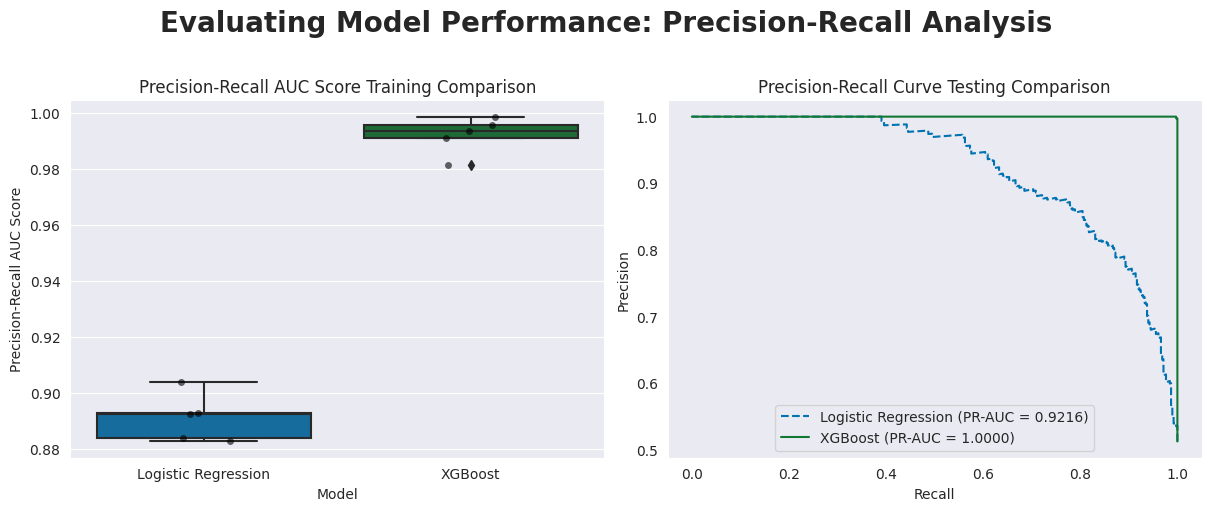

In [ ]:


# Precision-Recall AUC DataFrame for Boxplot
auc_df = pd.DataFrame({
    "Precision-Recall AUC Score": np.concatenate([cv_results_logreg, cv_results_xgb['train-aucpr-mean']]),
    "Model": ["Logistic Regression"] * len(cv_results_logreg) + ["XGBoost"] * len(cv_results_xgb),
    "Fold": list(range(1, len(cv_results_logreg) + 1)) + list(range(1, len(cv_results_xgb) + 1))
})

# Create subplots for visualizing the comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# 📌 Subplot 1: PR-AUC Scores (Boxplot & Stripplot)
ax = axes[0]
sns.boxplot(x="Model", y="Precision-Recall AUC Score", data=auc_df, palette=[palette[-1], palette[3]], ax=ax)
sns.stripplot(x="Model", y="Precision-Recall AUC Score", data=auc_df, color="black", alpha=0.6, jitter=True, ax=ax)

ax.set_title("Precision-Recall AUC Score Training Comparison")
ax.set_ylabel("Precision-Recall AUC Score")
ax.set_xlabel("Model")

# 📌 Subplot 2: Precision-Recall Curve
ax = axes[1]

# Get probability scores for each model
y_prob_logreg = logreg_classifier.predict_proba(X_test)[:, 1]  # Logistic Regression probabilities
y_prob_xgb = xgb_classifier.predict_proba(X_test)[:, 1]  # XGBoost probabilities

# Compute Precision-Recall Curve and PR-AUC for Logistic Regression
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, y_prob_logreg)
pr_auc_logreg = average_precision_score(y_test, y_prob_logreg)

# Compute Precision-Recall Curve and PR-AUC for XGBoost
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc_xgb = average_precision_score(y_test, y_prob_xgb)

# Plot Precision-Recall curves
ax.plot(recall_logreg, precision_logreg, label=f'Logistic Regression (PR-AUC = {pr_auc_logreg:.4f})', linestyle='--', color=palette[-1])
ax.plot(recall_xgb, precision_xgb, label=f'XGBoost (PR-AUC = {pr_auc_xgb:.4f})', linestyle='-', color=palette[3])

# Labels & Legend
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve Testing Comparison")
ax.legend(loc="lower center")
ax.grid()

# Overall title
fig.suptitle('Evaluating Model Performance: Precision-Recall Analysis\n', fontsize=20, weight='bold')

plt.show()


/tmp/ipykernel_31/2259996252.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')
/tmp/ipykernel_31/2259996252.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues')


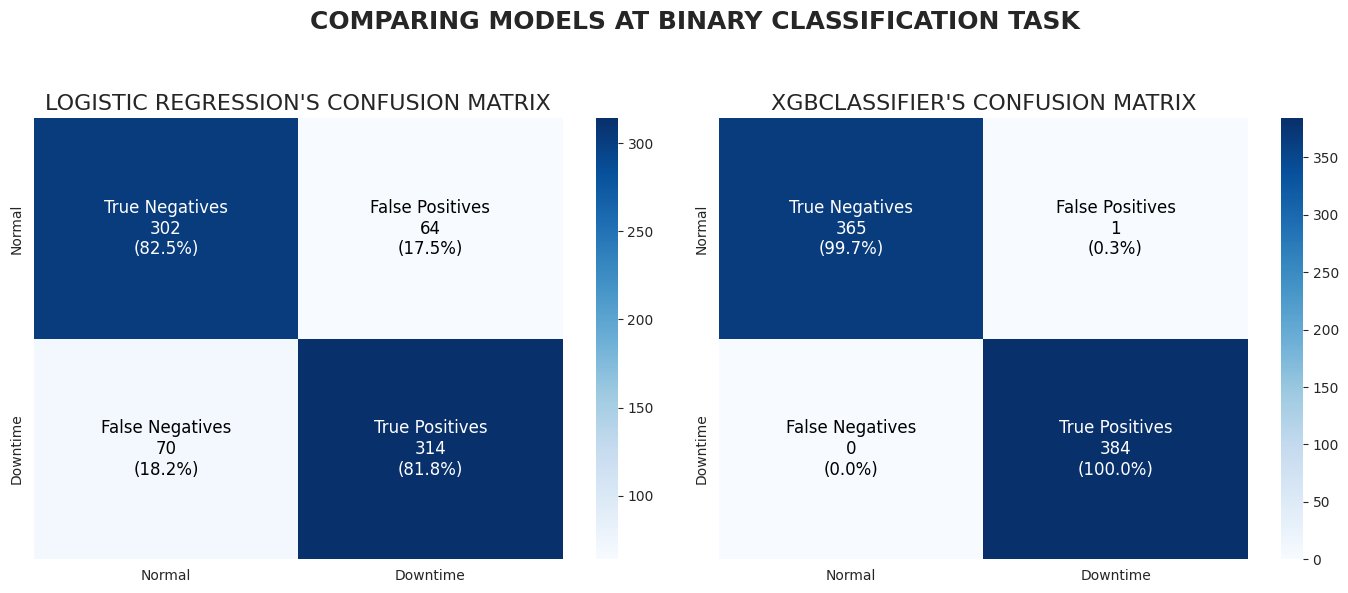

In [ ]:
# Function to annotate heatmap with counts, percentages by class, and custom labels
def annotate_heatmap(matrix, ax, title, cell_labels=None):
    # Normalize matrix by row to calculate the percentage per class (row)
    row_sums = matrix.sum(axis=1, keepdims=True)
    matrix_percentage = matrix / row_sums * 100
    cell_labels = [["True Negatives", "False Positives"], ["False Negatives", "True Positives"]]

    # Create heatmap
    heatmap = sns.heatmap(matrix, annot=False, fmt='g', cmap='Blues',
                          xticklabels=['Normal', 'Downtime'],
                          yticklabels=['Normal', 'Downtime'], ax=ax)

    cmap = plt.cm.get_cmap('Blues')
    norm = plt.Normalize(vmin=matrix.min(), vmax=matrix.max())

    # Add counts, percentages, and custom labels
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            count = matrix[i, j]
            percent = matrix_percentage[i, j]
            label_text = f"{count}\n({percent:.1f}%)"

            # If custom labels are provided, use them
            if cell_labels is not None:
                label_text = f"{cell_labels[i][j]}\n{label_text}"

            # Get the background color of the cell
            color = cmap(norm(matrix[i, j]))
            text_color = "white" if color[0]*0.299 + color[1]*0.587 + color[2]*0.114 < 0.5 else "black"

            # Add text with appropriate color
            ax.text(j + 0.5, i + 0.5, label_text, ha='center', va='center', color=text_color, fontsize=12)

    ax.set_title(title.upper(), fontsize=16)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
annotate_heatmap(lr_confusion_matrix, axes[0], "Logistic Regression's Confusion Matrix")
annotate_heatmap(xgb_confusion_matrix, axes[1], "XGBClassifier's Confusion Matrix")

fig.suptitle("COMPARING MODELS AT BINARY CLASSIFICATION TASK", weight='bold', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

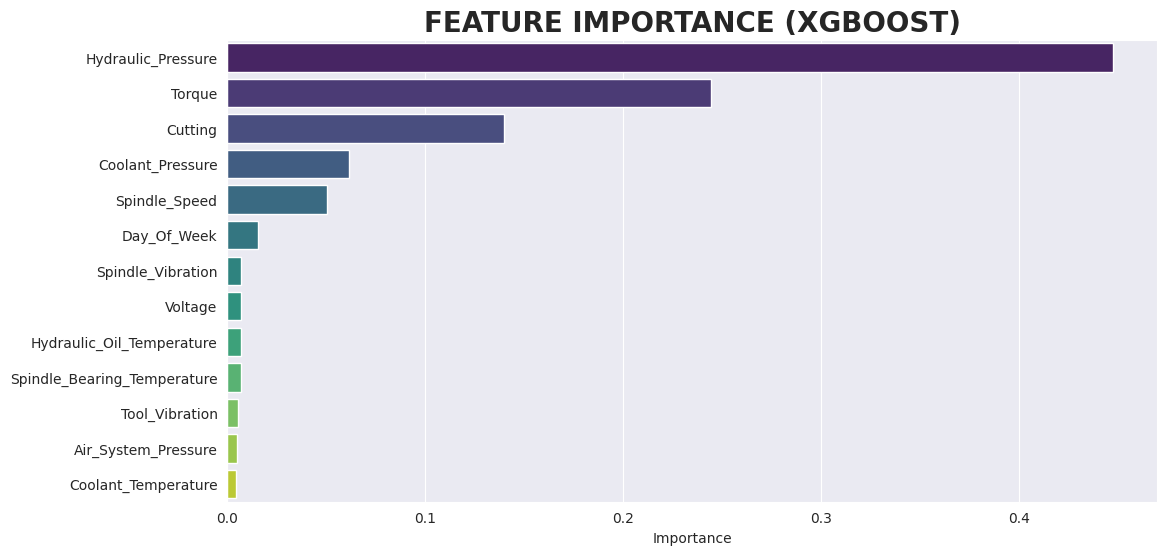

In [ ]:
# Feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_classifier.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.ylabel("")
plt.title("Feature Importance (XGBoost)".upper(), weight='bold', fontsize=20)
plt.show()

XGBoost's feature importance reveals how often a feature is used in decision tree splits and its contribution to model performance. Hydraulic Pressure was the most influential, contributing 40% of the total importance. Torque and Cutting Force followed with over 10% each, highlighting their roles in the model's decision-making.

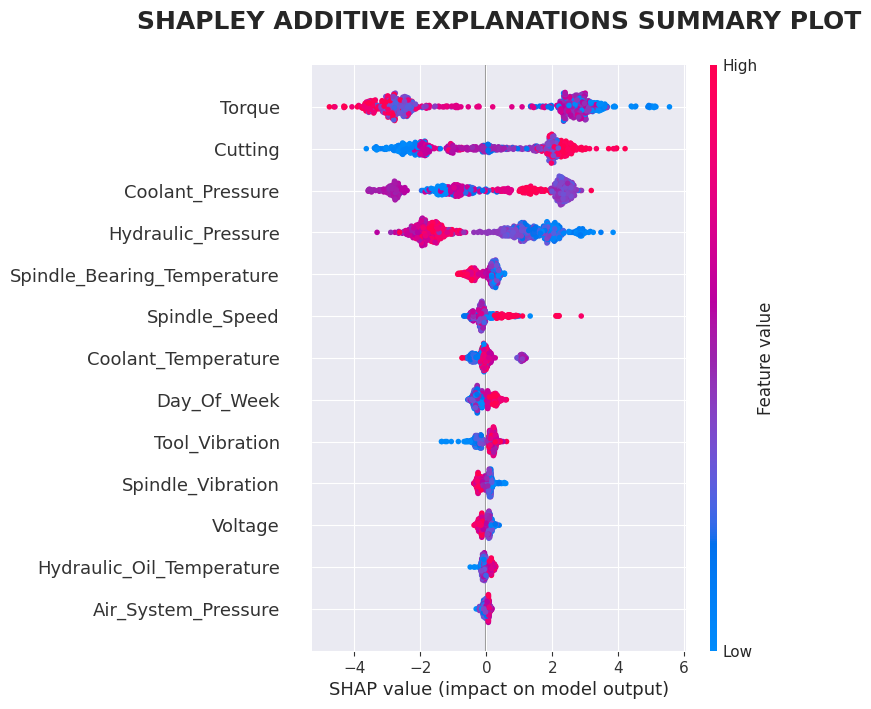

In [ ]:


index = 4 #row_to_show
data_for_prediction = X_test.iloc[index]
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
preds = xgb_classifier.predict_proba(data_for_prediction_array)

explainer = shap.TreeExplainer(xgb_classifier, feature_perturbation="interventional", model_output="raw")
shap_values = explainer.shap_values(X_test, check_additivity=False)

plt.figure(figsize=(8, 3))  # Define size before SHAP plot
shap.summary_plot(shap_values, X_test, show=False)  # Prevent auto-display
plt.title("SHapley Additive Explanations Summary Plot\n".upper(), weight='bold', fontsize=18)
plt.show()

SHAP (SHapley Additive Explanations) provides a deeper insight into how each feature influences individual predictions. Unlike feature importance, which shows feature usage in splits, SHAP quantifies the direct impact on predictions. Torque, Cutting, Coolant Pressure, and Hydraulic Pressure emerged as the most impactful, reflecting stronger nonlinear interactions. While Hydraulic Pressure was frequently used in splits, it may not always have the highest impact on each prediction, explaining its lower SHAP ranking.

In [ ]:
# SHAP force plot results
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index])

The SHAP analysis shows that key features—Torque (27.96), Cutting (3.67), Coolant Pressure (4.258), Hydraulic Pressure (77.59), and Coolant Temperature (18.5)—pushed the model to predict downtime with 99.97% confidence. These values significantly increased the downtime probability, highlighting the model's ability to identify high-risk patterns for preventive action.

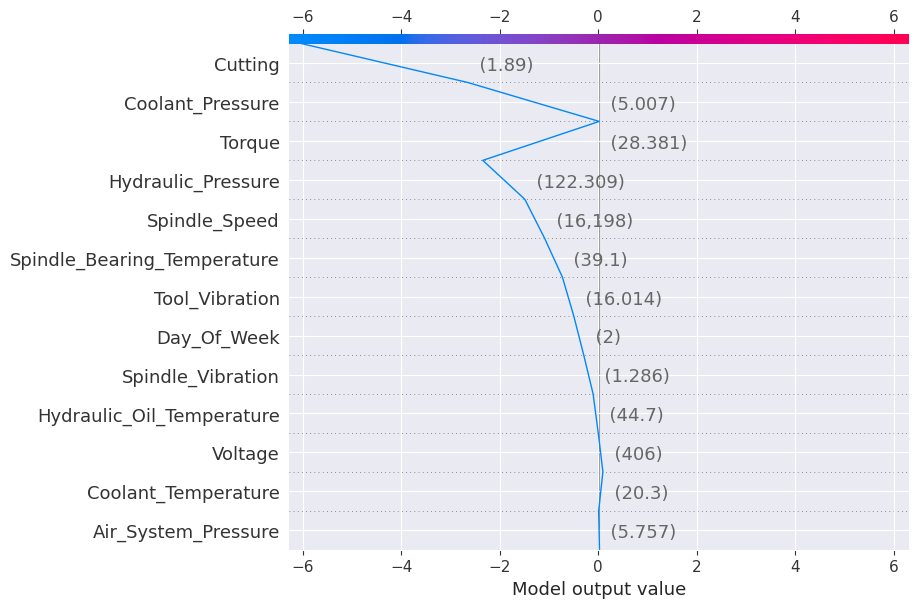

In [ ]:
# Decision plot (tracks how a decision is made)
shap.decision_plot(explainer.expected_value, shap_values[index], X_test.iloc[index])

The decision plot shows how SHAP values influence the prediction, with Torque, Cutting, and Coolant Pressure being the strongest contributors to predicting downtime. Some features, like Air System Pressure, slightly reduced the downtime prediction, but their impact was weaker. The final prediction, f(x) = 8.28, leads to a 99.97% probability of downtime, confirming the model's confidence.

**Data Quality & Collection:**

The data has good overall quality with no duplicates and low missingness, though uneven data collection across time and machines suggests potential gaps or biases. Sensor anomalies, like near-zero values for Spindle Vibration and Torque, raise concerns about sensor reliability.

**Downtime Trends:**

Downtime occurred weekly, with Saturdays having 100% downtime. From February to June, downtime averaged 50%. The Makino-L1-Unit1-2013 machine had the highest downtime rates and the most 100% downtime days, followed closely by Makino-L3-Unit1-2015 and Makino-L2-Unit1-2015.

**Key Downtime Factors:**

Statistical analysis shows lower Hydraulic Pressure, lower Torque, and higher Cutting Force are strongly associated with downtime. XGBoost outperformed Logistic Regression with better PR-AUC and accuracy. Hydraulic Pressure, Torque, and Cutting are the most impactful features according to XGBoost, while SHAP highlights Torque, Cutting, Coolant Pressure, and Hydraulic Pressure as key contributors.